<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C1W3_Convolutional_Neural_Networks_1_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Please use GPU for this notebook!

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Improving Computer Vision Accuracy using Convolutions

In the previous lessons you saw how to do fashion recognition using a Deep Neural Network (DNN) containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and a hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy.

For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end. 

In [0]:
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images / 255.0
test_images=test_images / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5035 - accuracy: 0.8228
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3790 - accuracy: 0.8638
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3392 - accuracy: 0.8773
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3132 - accuracy: 0.8848
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3621 - accuracy: 0.8702


Your accuracy is probably about 89% on training and 87% on validation...not bad...But how do you make that even better? One way is to use something called Convolutions. I'm not going to details on Convolutions here, but the ultimate concept is that they narrow down the content of the image to focus on specific, distinct, details. 

If you've ever done image processing using a filter (like this: https://en.wikipedia.org/wiki/Kernel_(image_processing)) then convolutions will look very familiar.

In short, you take an array (usually 3x3 or 5x5) and pass it over the image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision, because often it's features that can get highlighted like this that distinguish one item from another, and the amount of information needed is then much less...because you'll just train on the highlighted features.

That's the concept of Convolutional Neural Networks. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focussed, and possibly more accurate.

Run the below code -- this is the same neural network as earlier, but this time with Convolutional layers added first. It will take longer, but look at the impact on the accuracy:

In [0]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

2.2.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 10)         

It's likely gone up to about 93% on the training data and 91% on the validation data. 

That's significant, and a step in the right direction!

Try running it for more epochs -- say about 20, and explore the results! But while the results might seem really good, the validation results may actually go down, due to something called 'overfitting' which will be discussed later. 

(In a nutshell, 'overfitting' occurs when the network learns the data from the training set really well, but it's too specialised to only that data, and as a result is less effective at seeing *other* data. For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it, but blue suade shoes might confuse you...and you know you should never mess with my blue suede shoes.)

Then, look at the code again, and see, step by step how the Convolutions were built:

Step 1 is to gather the data. You'll notice that there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape. 



```
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
```


Next is to define your model. Now instead of the input layer at the top, you're going to add a Convolution. The parameters are:

1. The number of convolutions you want to generate. Purely arbitrary, but good to start with something in the order of 32
2. The size of the Convolution, in this case a 3x3 grid
3. The activation function to use -- in this case we'll use relu, which you might recall is the equivalent of returning x when x>0, else returning 0
4. In the first layer, the shape of the input data.

You'll follow the Convolution with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1. It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.

You can call model.summary() to see the size and shape of the network, and you'll notice that after every MaxPooling layer, the image size is reduced in this way. 


```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```


Add another convolution



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
```


Now flatten the output. After this you'll just have the same DNN structure as the non convolutional version

```
  tf.keras.layers.Flatten(),
```


The same 128 dense layers, and 10 output layers as in the pre-convolution example:



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```


Now compile the model, call the fit method to do the training, and evaluate the loss and accuracy from the test set.



```
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)
```


EXERCISES

1. Try editing the convolutions. Change the 32s to either 16 or 64. What impact will this have on accuracy and/or training time.

2. Remove the final Convolution. What impact will this have on accuracy or training time?

3. How about adding more Convolutions? What impact do you think this will have? Experiment with it.

4. Remove all Convolutions but the first. What impact do you think this will have? Experiment with it. 

5. In the previous lesson you implemented a callback to check on the loss function and to cancel training once it hit a certain amount. See if you can implement that here!

# Consider each layer as an output and look how an input image is transformed by each layer - scroll right to see all layers

In [0]:
layer_outputs = [layer.output for layer in model.layers]
print('layer_outputs')
print(layer_outputs)

activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
print('activation_model')
print(activation_model)

layer_outputs
[<tf.Tensor 'conv2d/Identity:0' shape=(None, 26, 26, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/Identity:0' shape=(None, 13, 13, 64) dtype=float32>, <tf.Tensor 'conv2d_1/Identity:0' shape=(None, 11, 11, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_1/Identity:0' shape=(None, 5, 5, 64) dtype=float32>, <tf.Tensor 'flatten_1/Identity:0' shape=(None, 1600) dtype=float32>, <tf.Tensor 'dense_2/Identity:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'dense_3/Identity:0' shape=(None, 10) dtype=float32>]
activation_model


# Visualizing the Convolutions and Pooling

This code will show us the convolutions graphically. The print (test_labels[;100]) shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [0]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


## Let's look at 3 samples of label 9: ankle boots (index 0,23, 28 in test_labels)

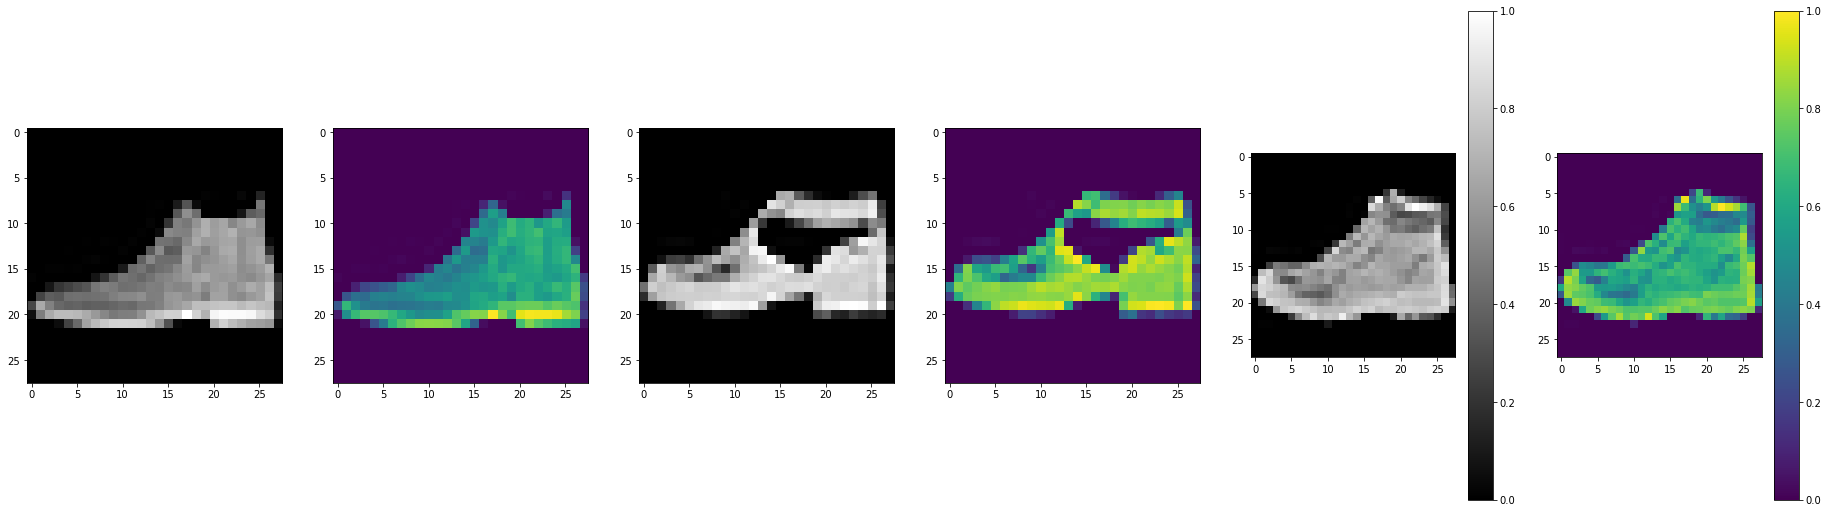

In [0]:
plt.figure(figsize=(32,9))

FIRST_IMAGE=0
image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

FIRST_IMAGE=23
image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

FIRST_IMAGE=28
image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 9: ankle boots after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

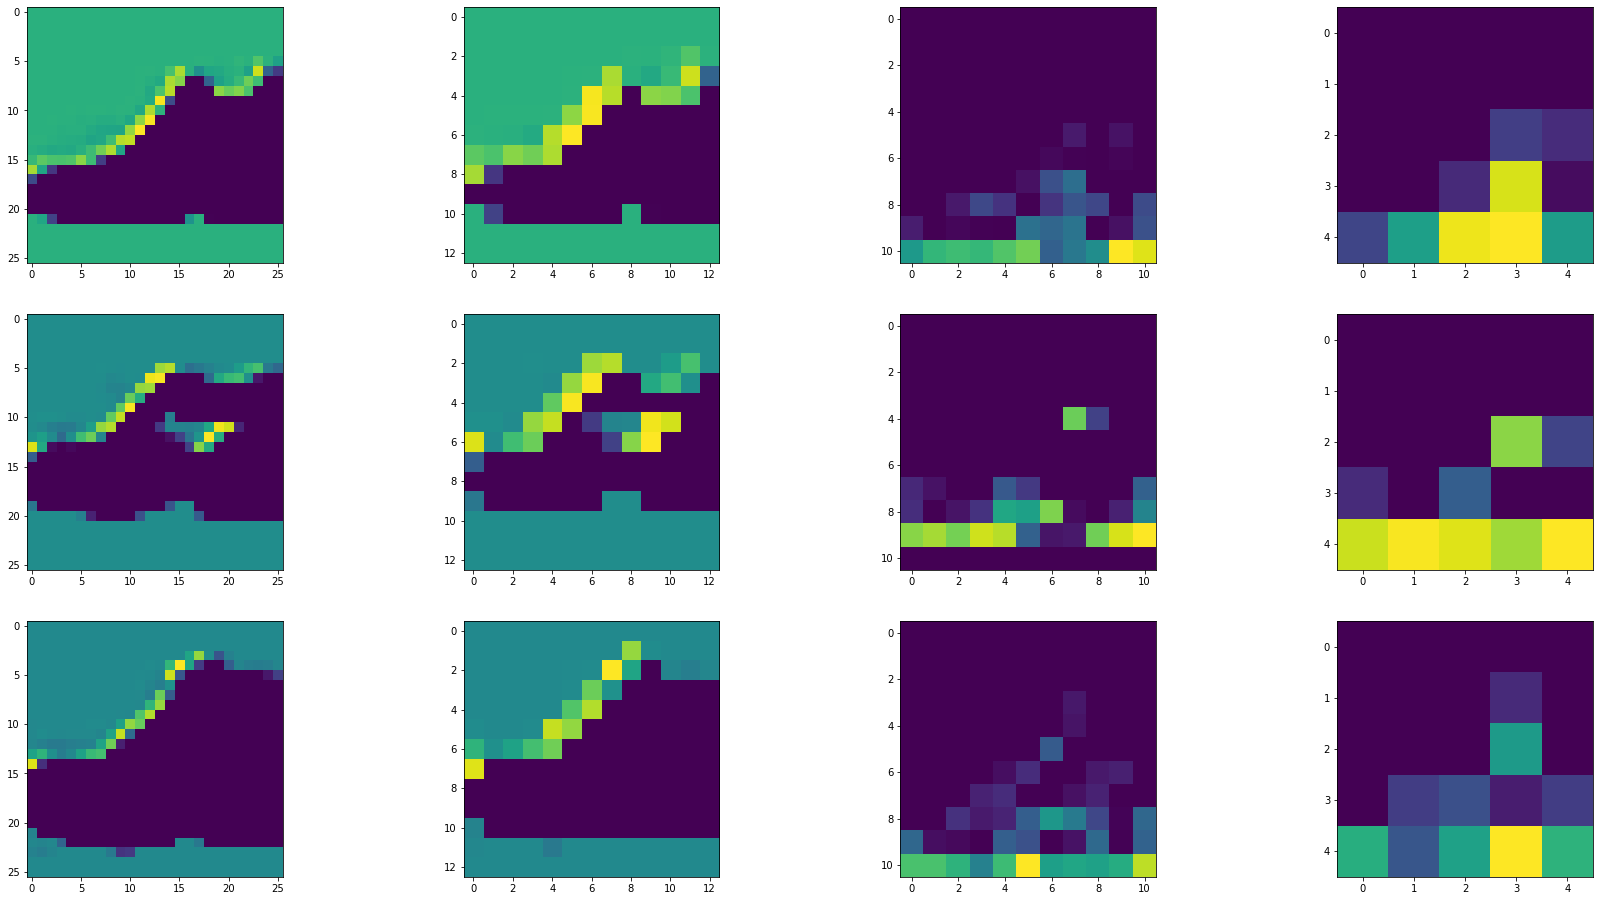

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

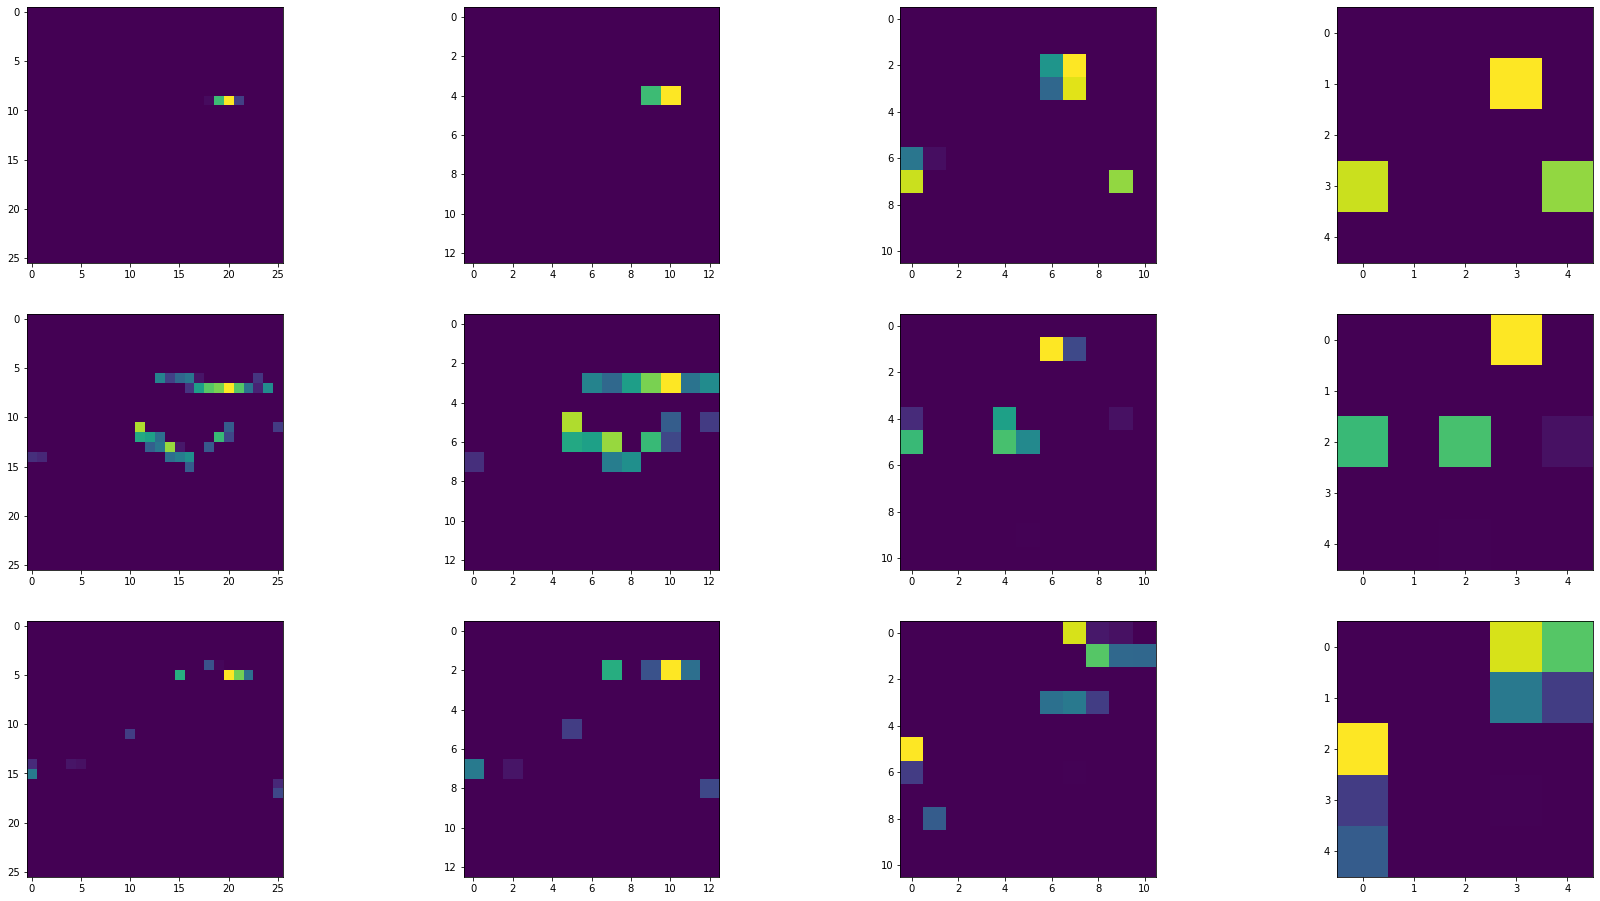

In [0]:
f, axarr = plt.subplots(3,4)
CONVOLUTION_NUMBER = 32

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)
  #if x == 1:
    #plt.colorbar(plt.pcolor(f1[0, : , :, CONVOLUTION_NUMBER]))
    #plt.colorbar(plt.pcolor(f1[0, : , :, CONVOLUTION_NUMBER], vmin=0, vmax=1))


  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

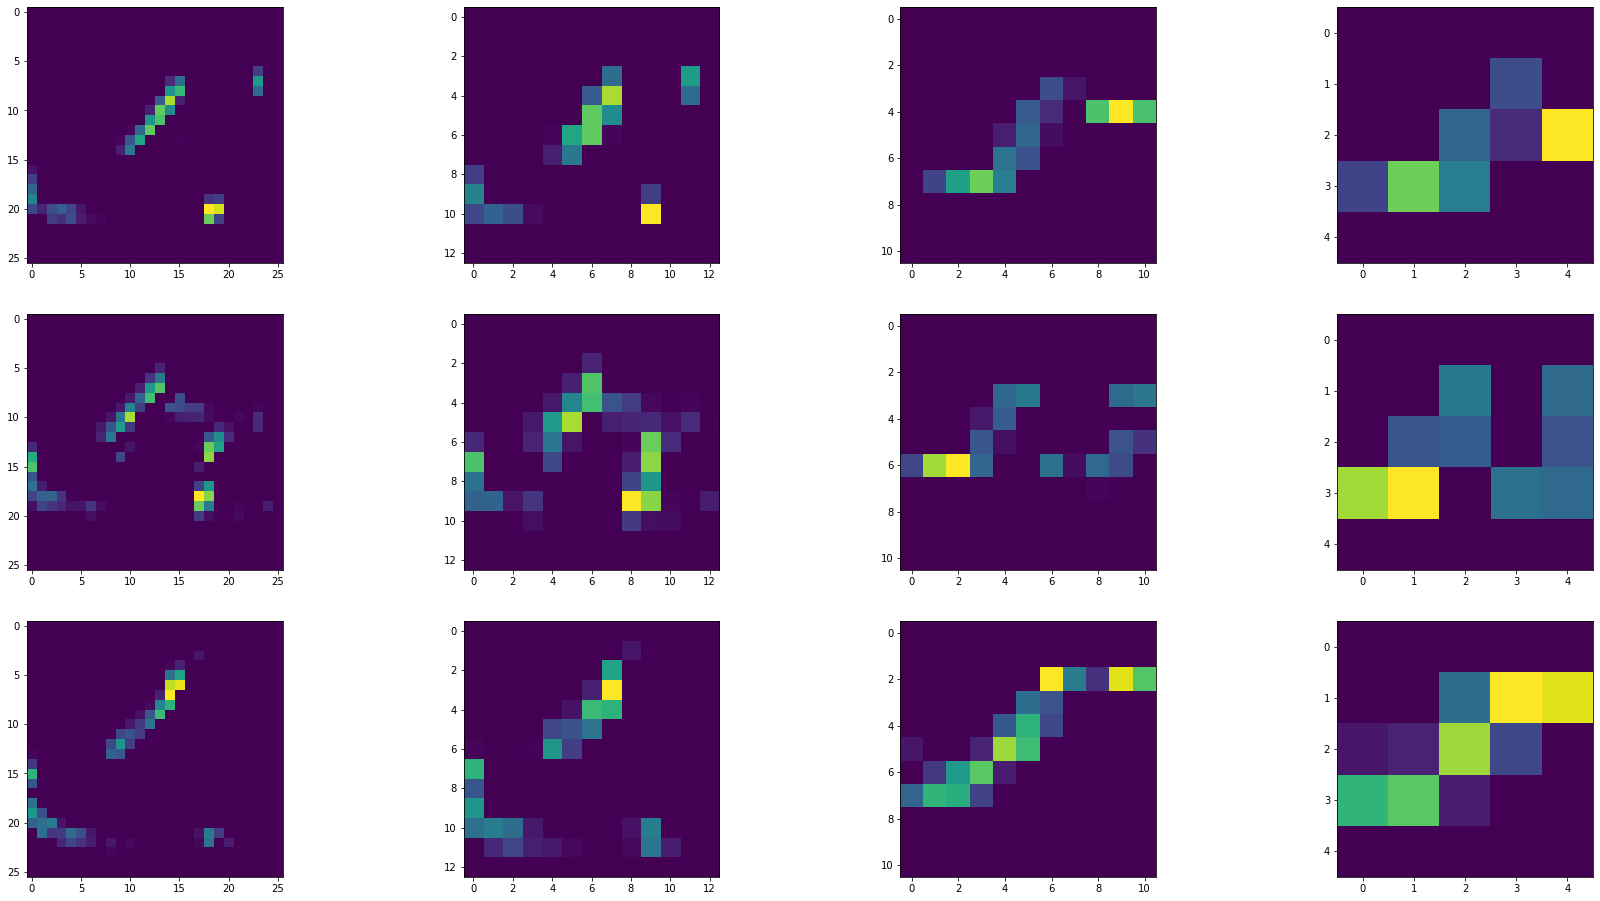

In [0]:
f, axarr = plt.subplots(3,4)
CONVOLUTION_NUMBER = 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)
  #if x == 1:
    #plt.colorbar(plt.pcolor(f1[0, : , :, CONVOLUTION_NUMBER]))
    #plt.colorbar(plt.pcolor(f1[0, : , :, CONVOLUTION_NUMBER], vmin=0, vmax=1))
  
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

# Visualizing all 64 Convolutions and Pooling - FIRST_IMAGE

<IPython.core.display.Javascript object>

CONVOLUTION_NUMBER: 0


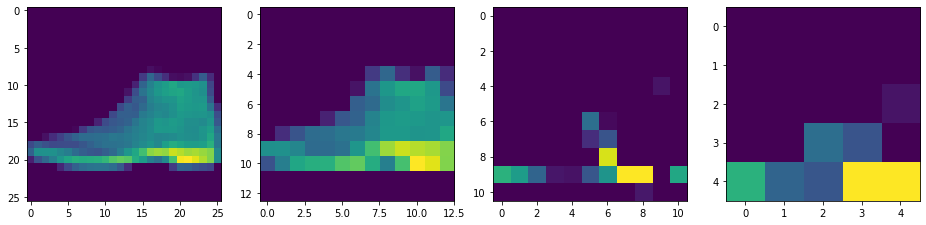

CONVOLUTION_NUMBER: 1


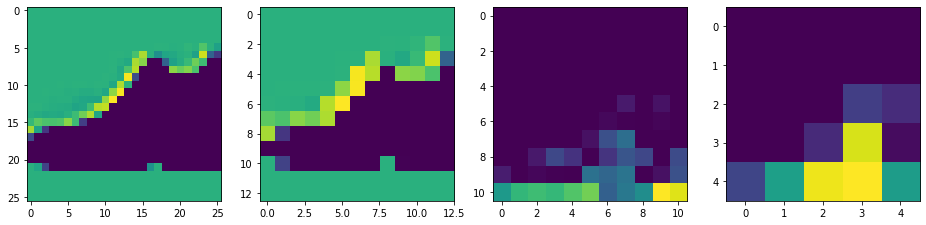

CONVOLUTION_NUMBER: 2


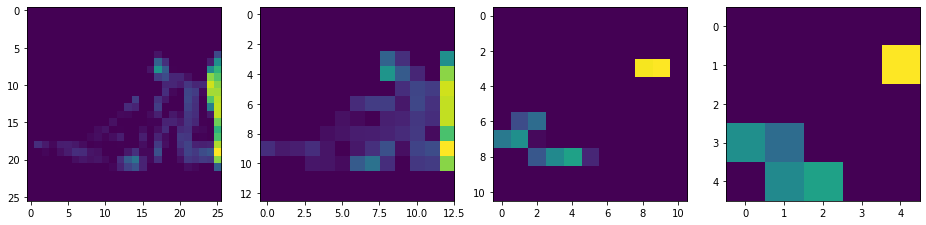

CONVOLUTION_NUMBER: 3


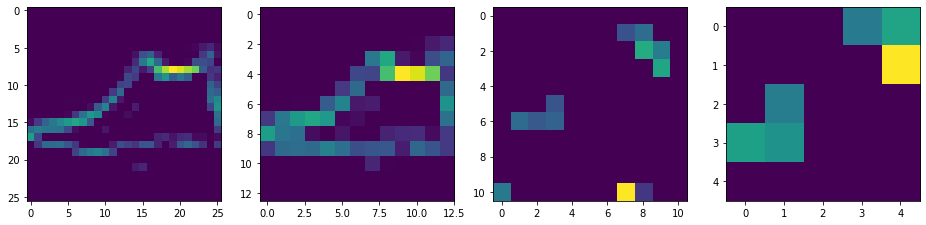

CONVOLUTION_NUMBER: 4


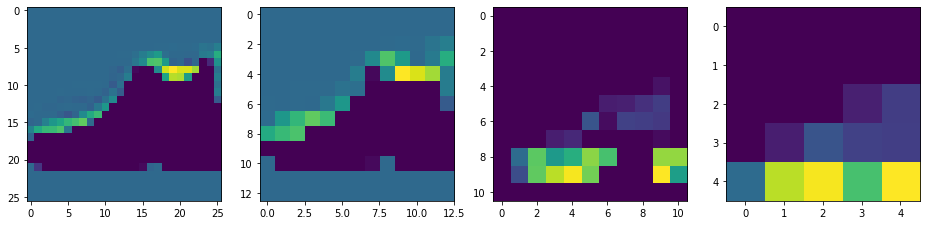

CONVOLUTION_NUMBER: 5


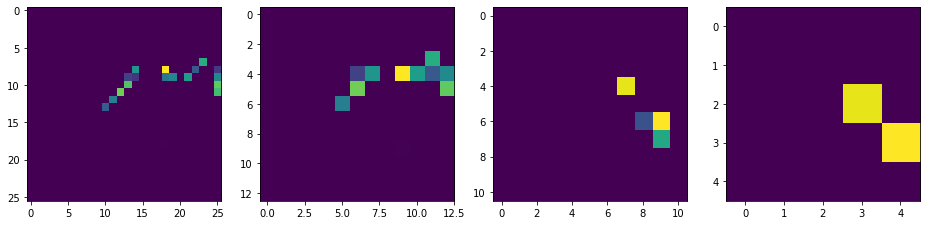

CONVOLUTION_NUMBER: 6


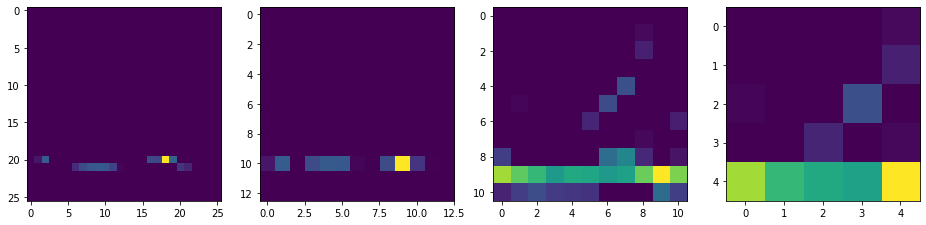

CONVOLUTION_NUMBER: 7


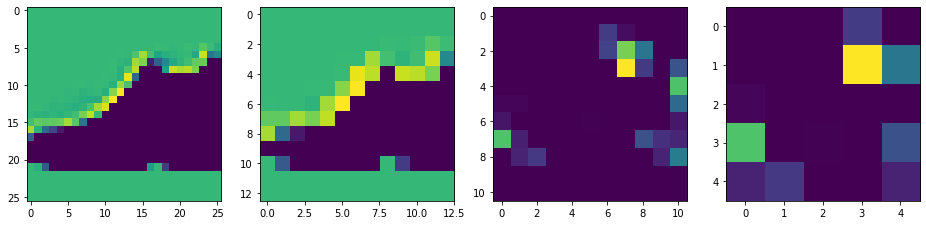

CONVOLUTION_NUMBER: 8


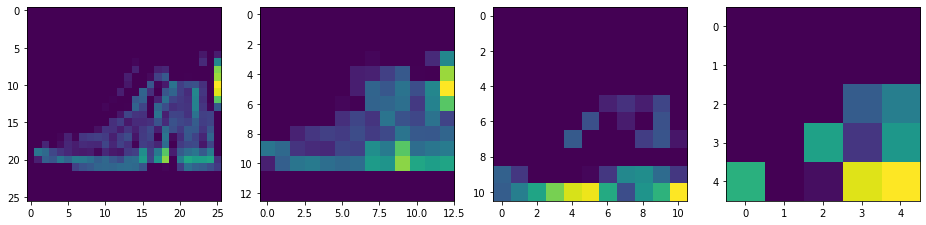

CONVOLUTION_NUMBER: 9


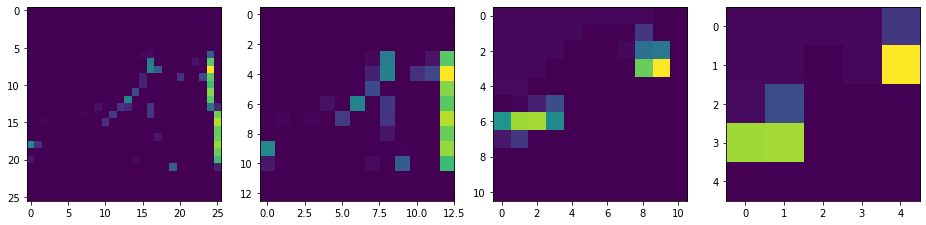

CONVOLUTION_NUMBER: 10


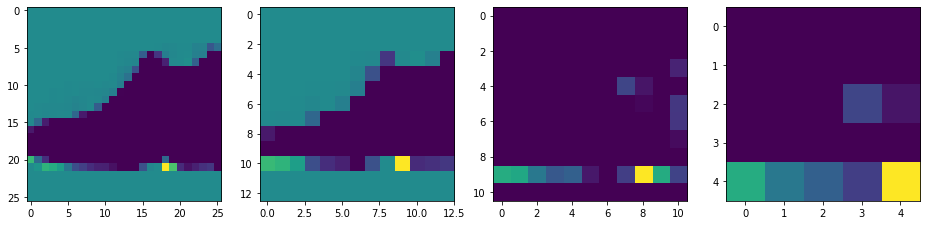

CONVOLUTION_NUMBER: 11


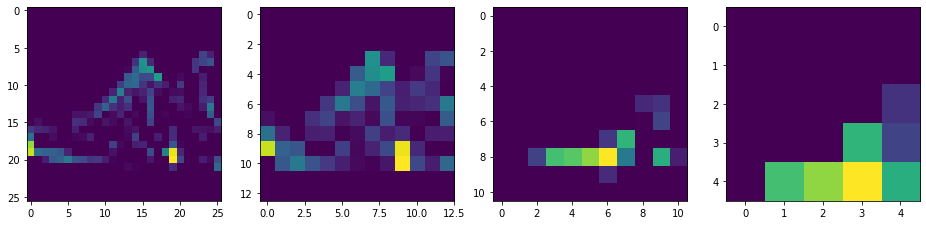

CONVOLUTION_NUMBER: 12


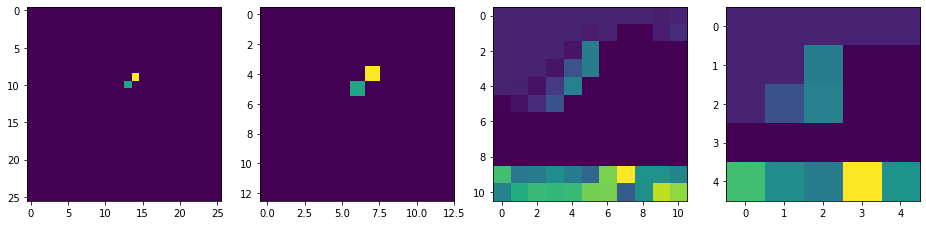

CONVOLUTION_NUMBER: 13


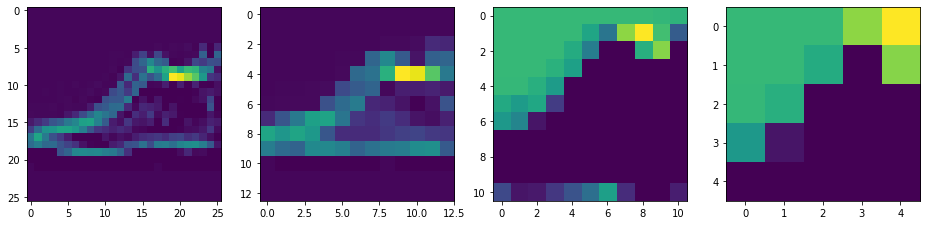

CONVOLUTION_NUMBER: 14


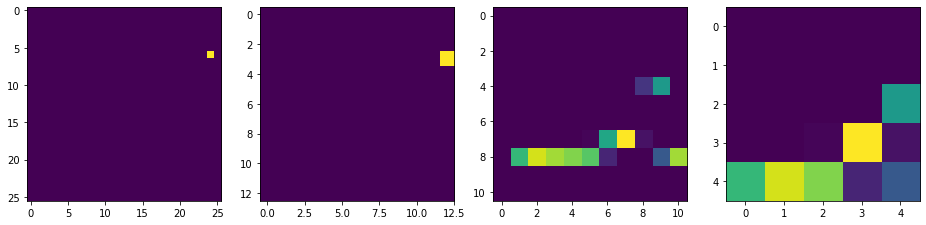

CONVOLUTION_NUMBER: 15


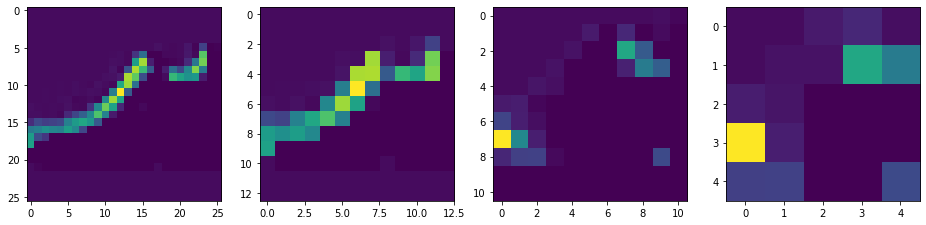

CONVOLUTION_NUMBER: 16


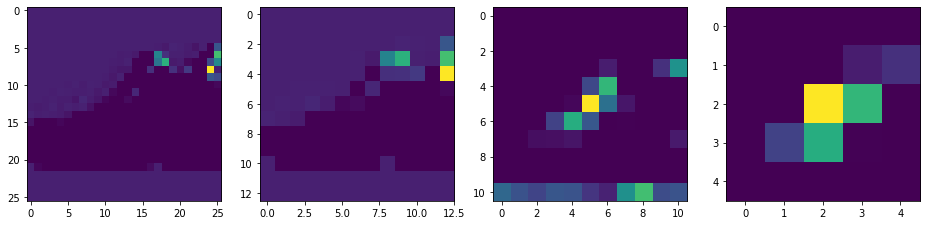

CONVOLUTION_NUMBER: 17


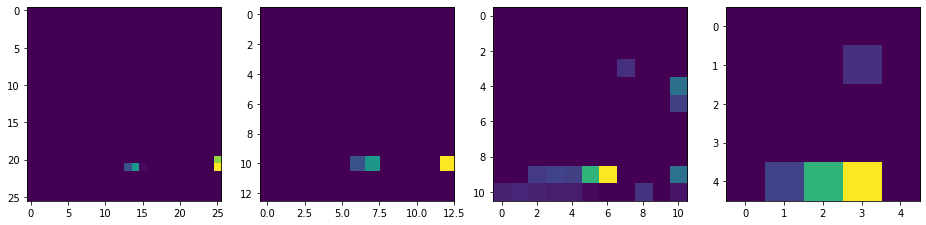

CONVOLUTION_NUMBER: 18


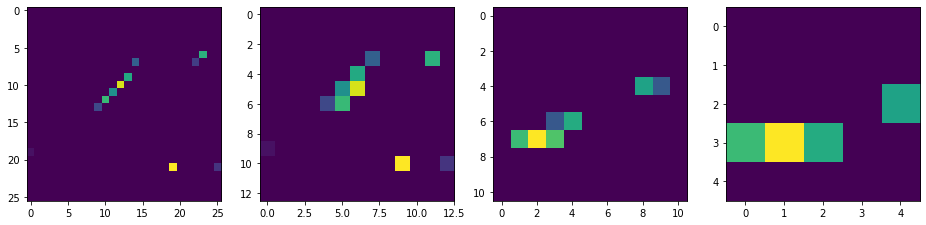

CONVOLUTION_NUMBER: 19


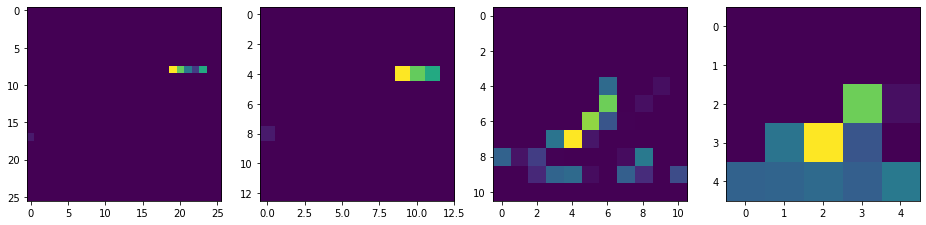

CONVOLUTION_NUMBER: 20


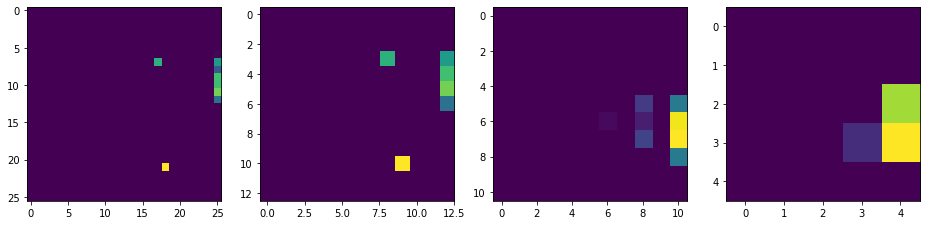

CONVOLUTION_NUMBER: 21


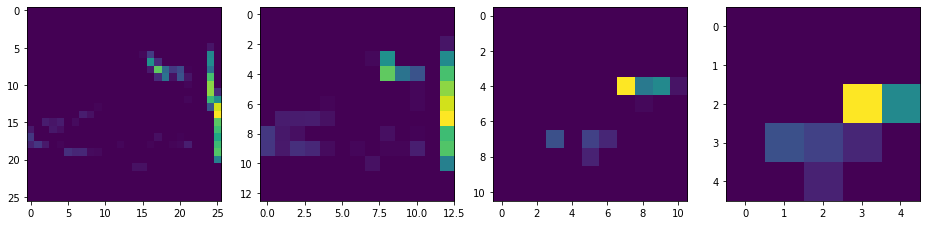

CONVOLUTION_NUMBER: 22


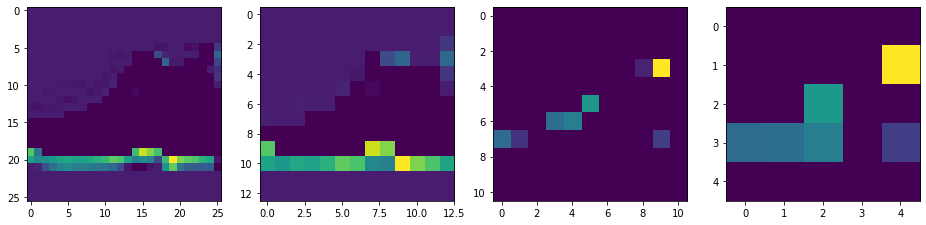

CONVOLUTION_NUMBER: 23


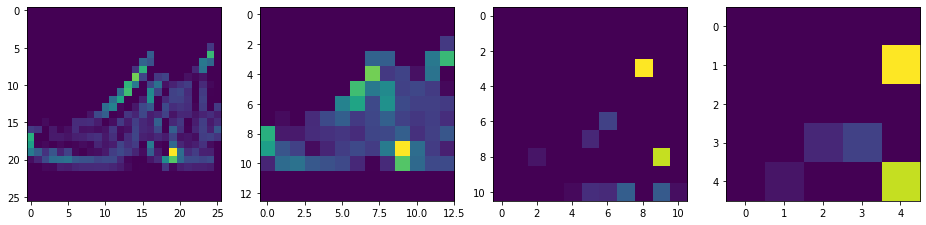

CONVOLUTION_NUMBER: 24


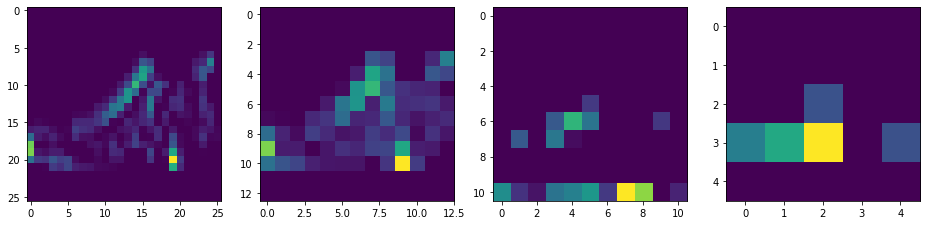

CONVOLUTION_NUMBER: 25


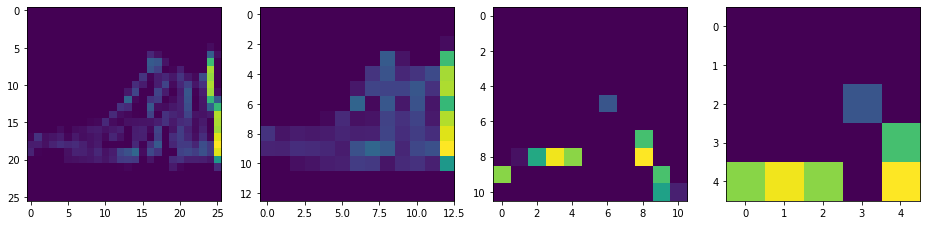

CONVOLUTION_NUMBER: 26


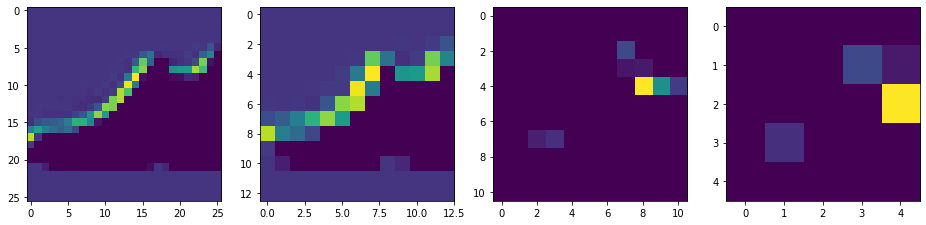

CONVOLUTION_NUMBER: 27


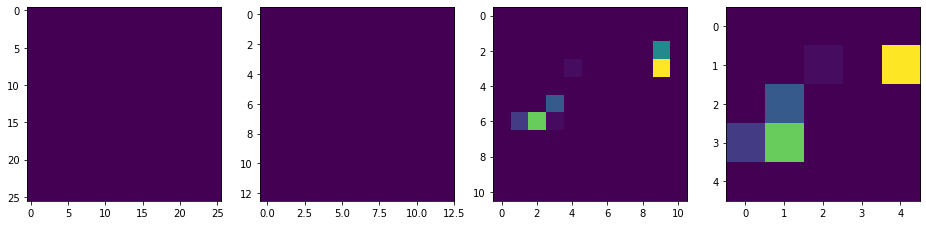

CONVOLUTION_NUMBER: 28


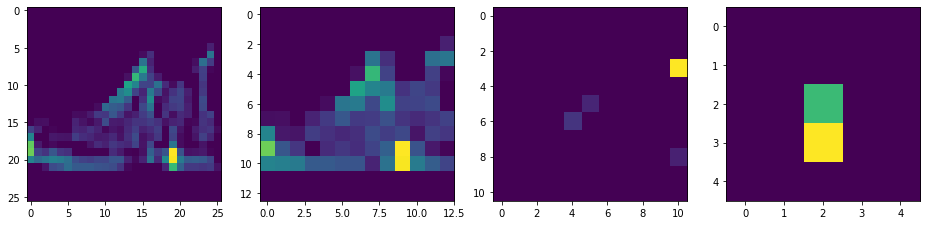

CONVOLUTION_NUMBER: 29


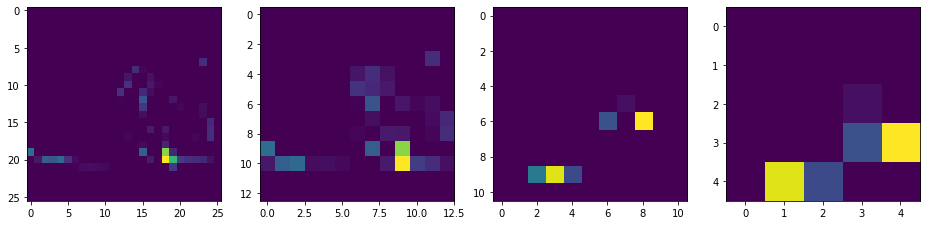

CONVOLUTION_NUMBER: 30


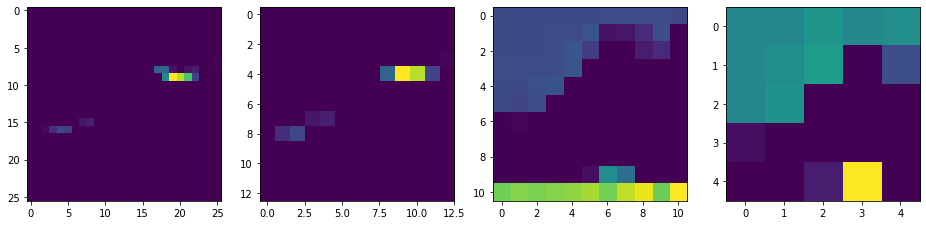

CONVOLUTION_NUMBER: 31


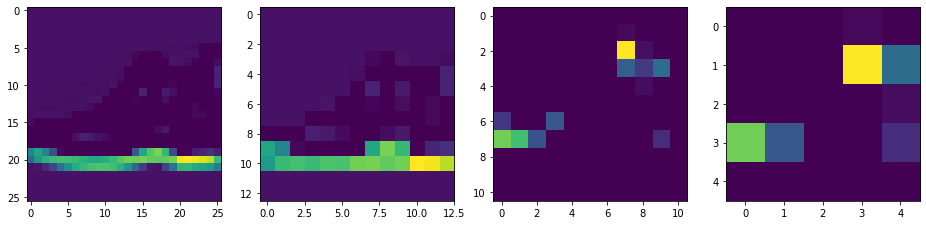

CONVOLUTION_NUMBER: 32


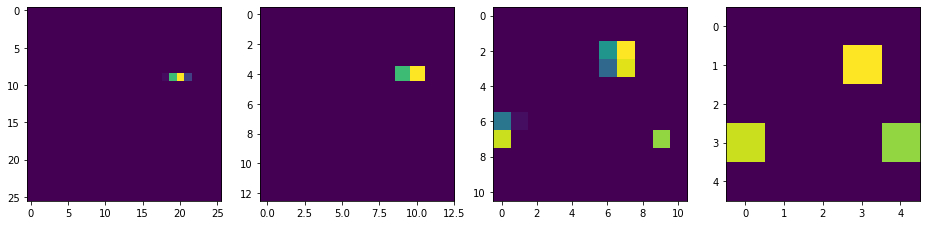

CONVOLUTION_NUMBER: 33


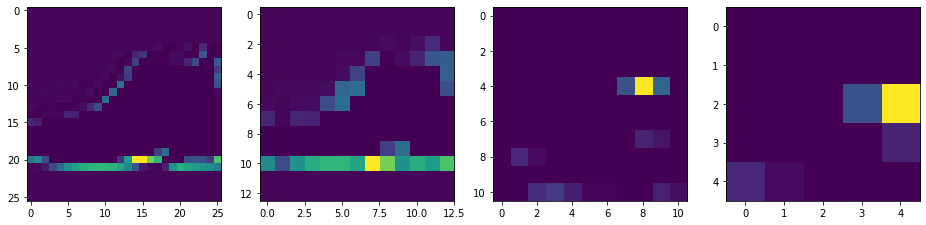

CONVOLUTION_NUMBER: 34


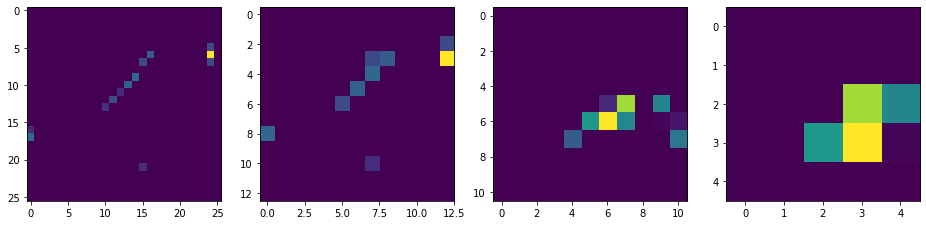

CONVOLUTION_NUMBER: 35


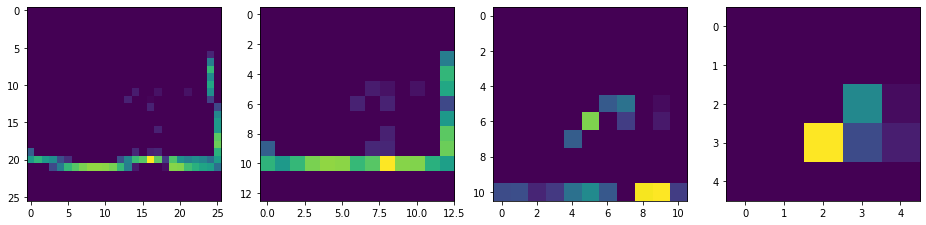

CONVOLUTION_NUMBER: 36


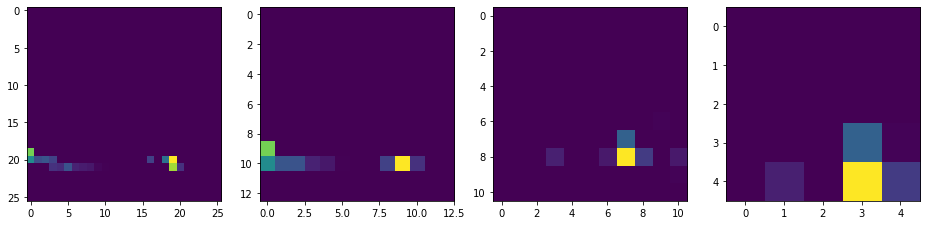

CONVOLUTION_NUMBER: 37


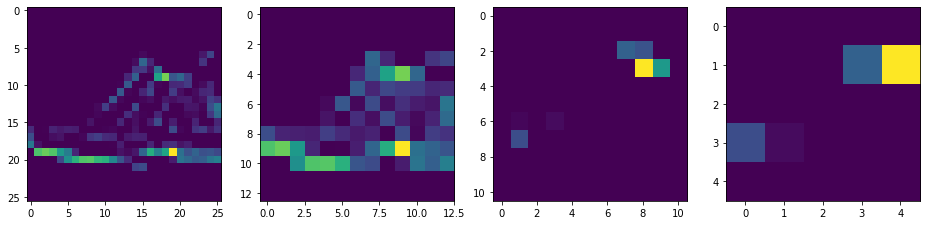

CONVOLUTION_NUMBER: 38


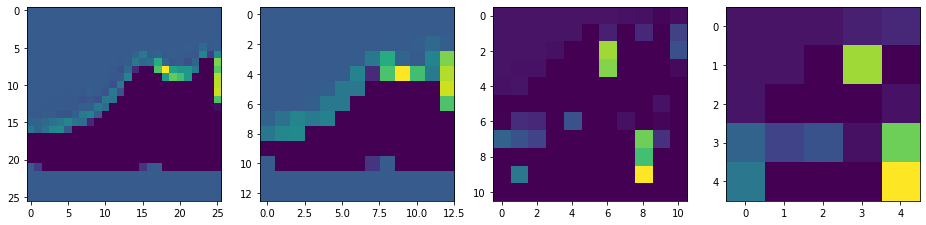

CONVOLUTION_NUMBER: 39


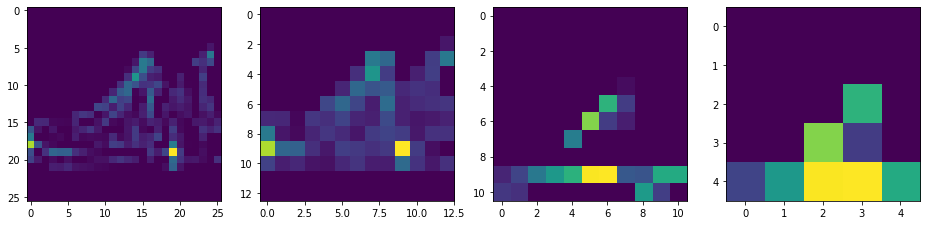

CONVOLUTION_NUMBER: 40


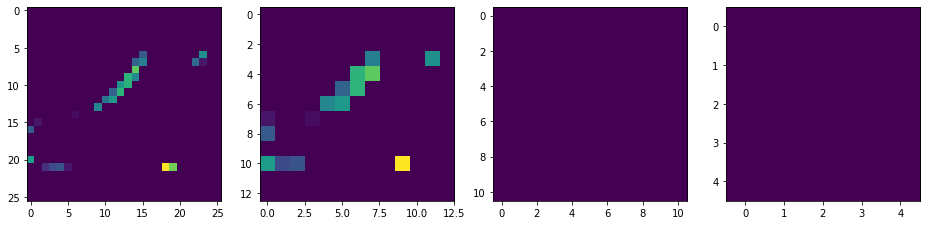

CONVOLUTION_NUMBER: 41


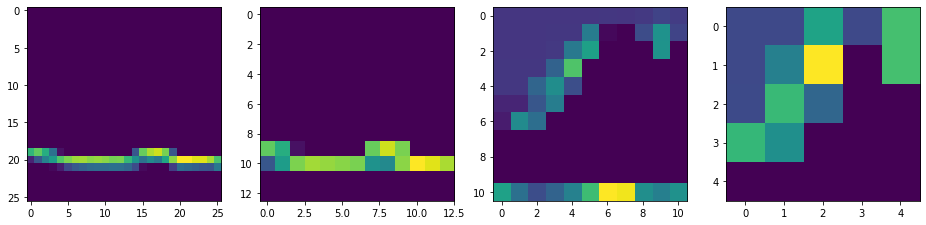

CONVOLUTION_NUMBER: 42


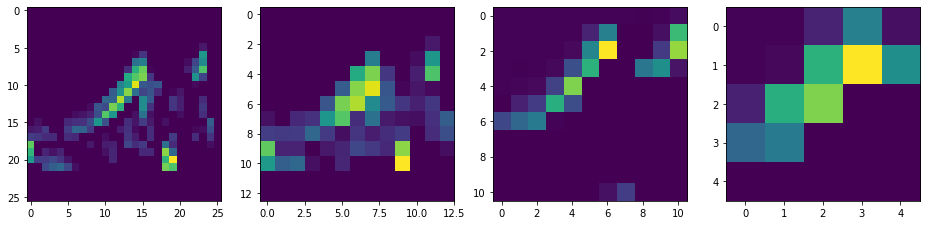

CONVOLUTION_NUMBER: 43


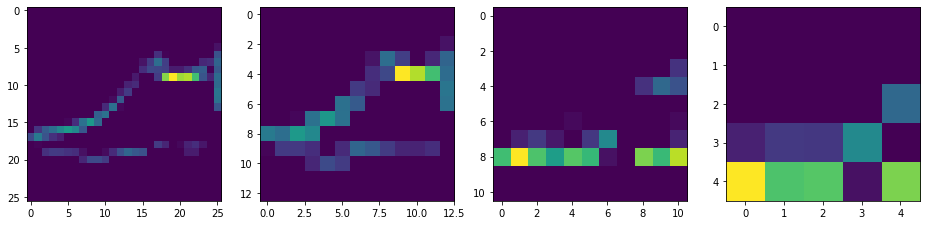

CONVOLUTION_NUMBER: 44


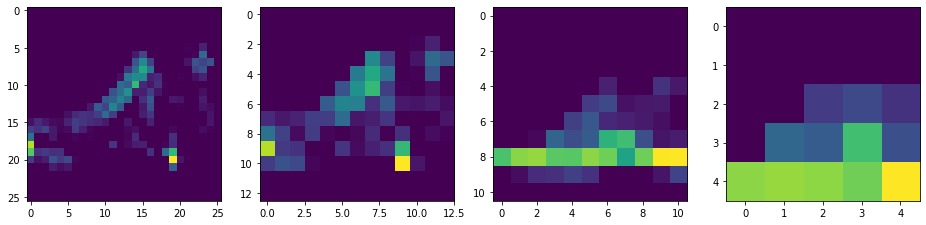

CONVOLUTION_NUMBER: 45


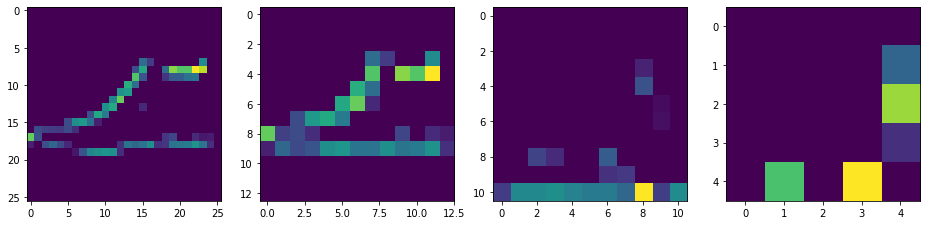

CONVOLUTION_NUMBER: 46


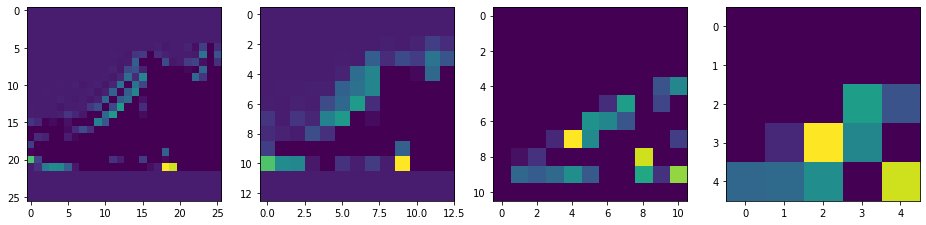

CONVOLUTION_NUMBER: 47


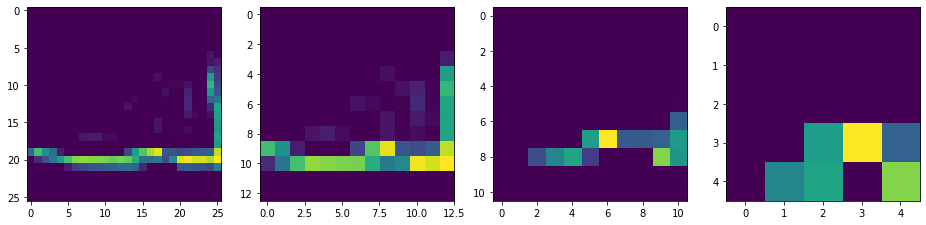

CONVOLUTION_NUMBER: 48


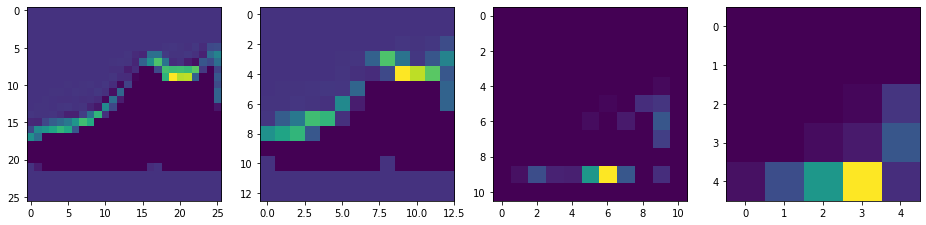

CONVOLUTION_NUMBER: 49


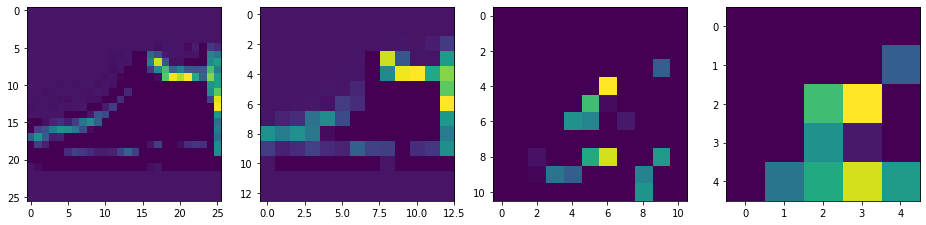

CONVOLUTION_NUMBER: 50


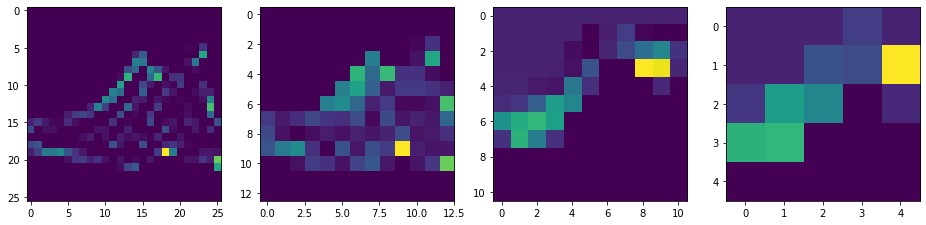

CONVOLUTION_NUMBER: 51


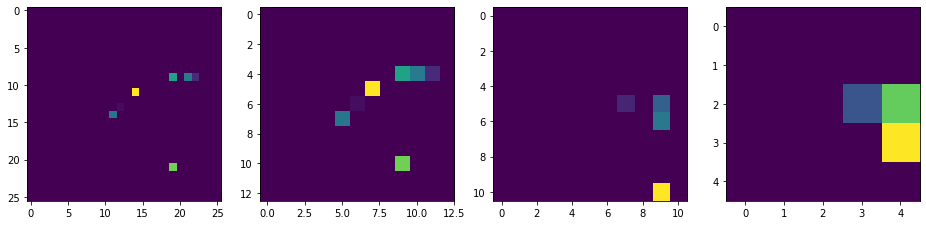

CONVOLUTION_NUMBER: 52


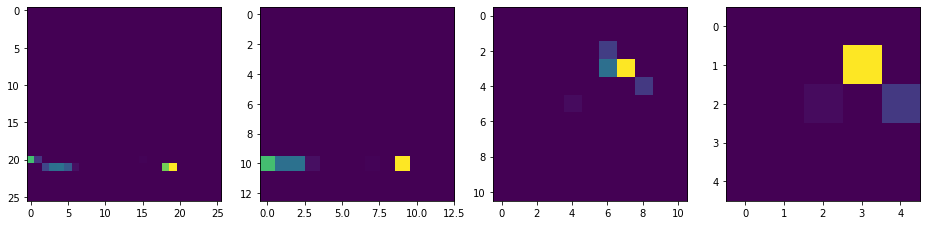

CONVOLUTION_NUMBER: 53


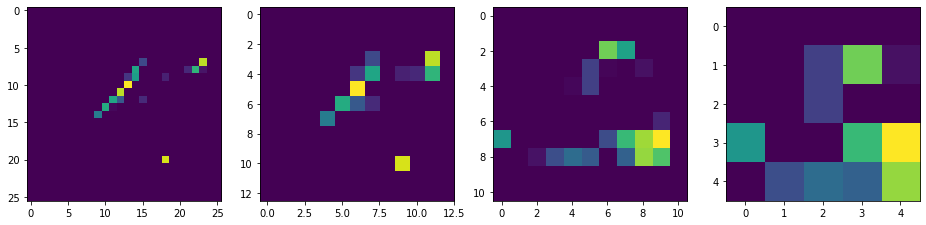

CONVOLUTION_NUMBER: 54


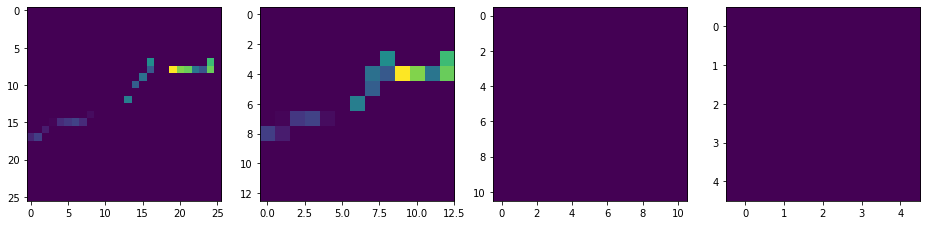

CONVOLUTION_NUMBER: 55


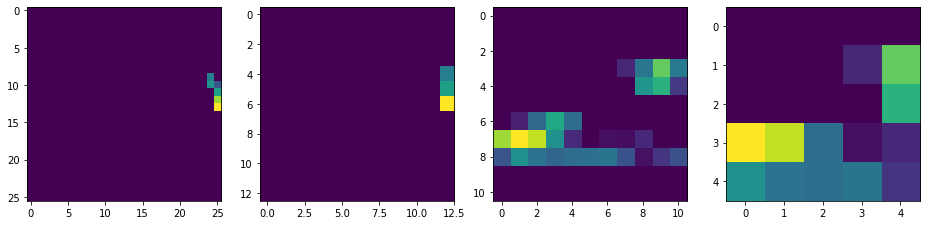

CONVOLUTION_NUMBER: 56


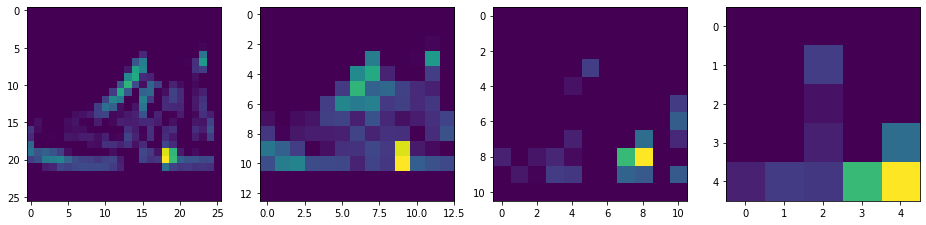

CONVOLUTION_NUMBER: 57


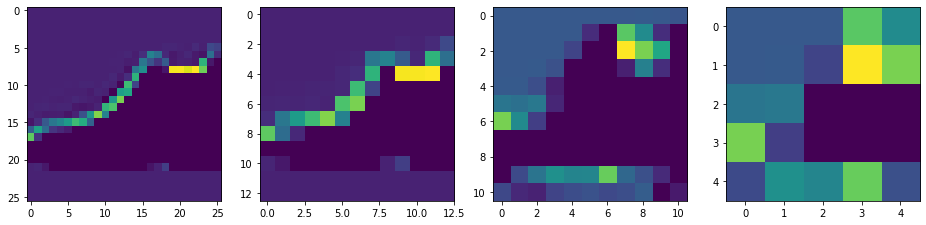

CONVOLUTION_NUMBER: 58


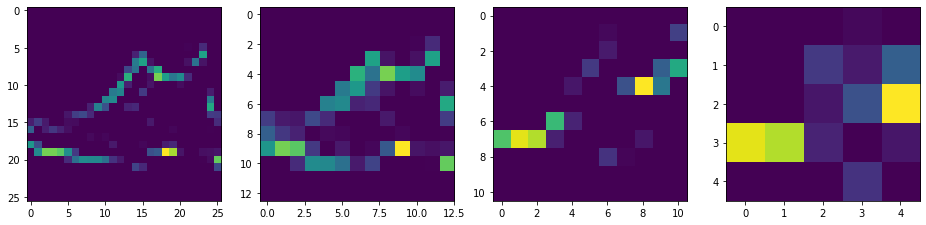

CONVOLUTION_NUMBER: 59


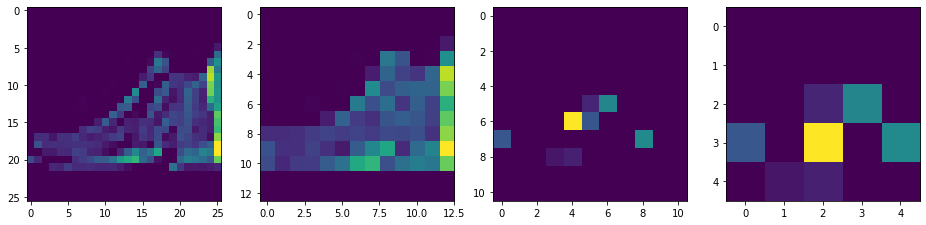

CONVOLUTION_NUMBER: 60


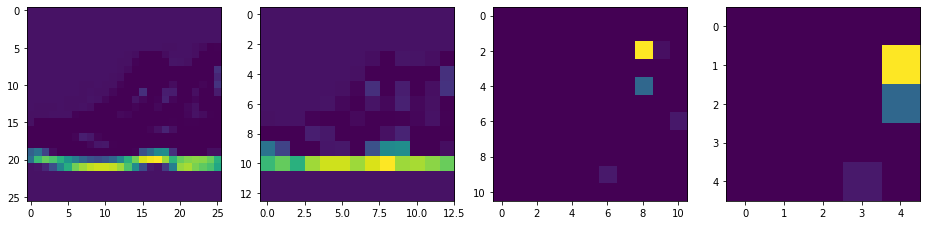

CONVOLUTION_NUMBER: 61


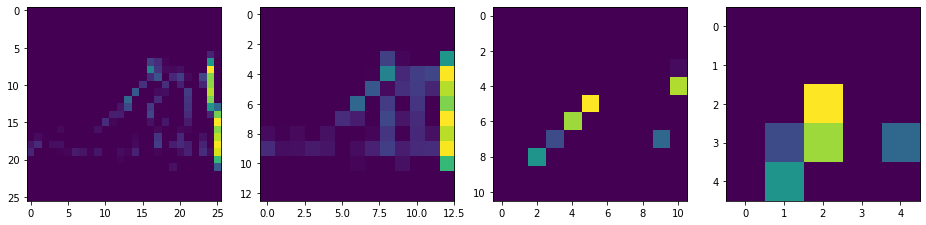

CONVOLUTION_NUMBER: 62


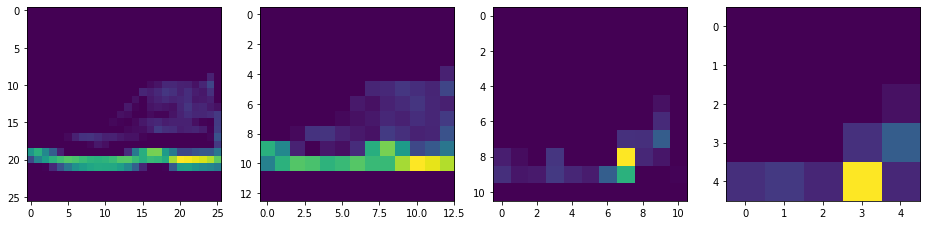

CONVOLUTION_NUMBER: 63


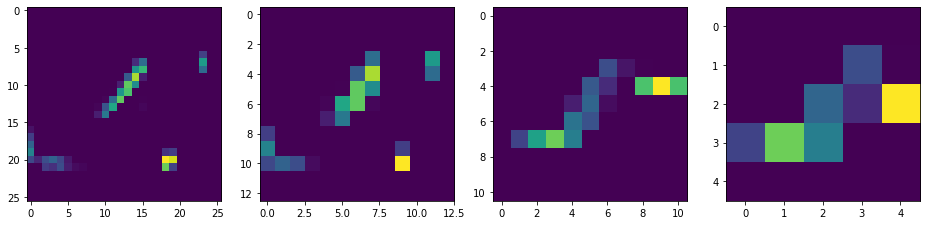

In [0]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

plt.rcParams["figure.figsize"] = [16,9]

CNN_final_layer_data = []

for CONVOLUTION_NUMBER in range(64):
  f, axarr = plt.subplots(1,4)
  print('CONVOLUTION_NUMBER:',CONVOLUTION_NUMBER)

  for x in range(0,4):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axarr[x].grid(False)

  CNN_final_layer_data.append(f1[0, : , :, CONVOLUTION_NUMBER])
  plt.show()  

# Visualizing all 64 Pooling Layers - FIRST_IMAGE

In [0]:
len(CNN_final_layer_data)

64

<IPython.core.display.Javascript object>

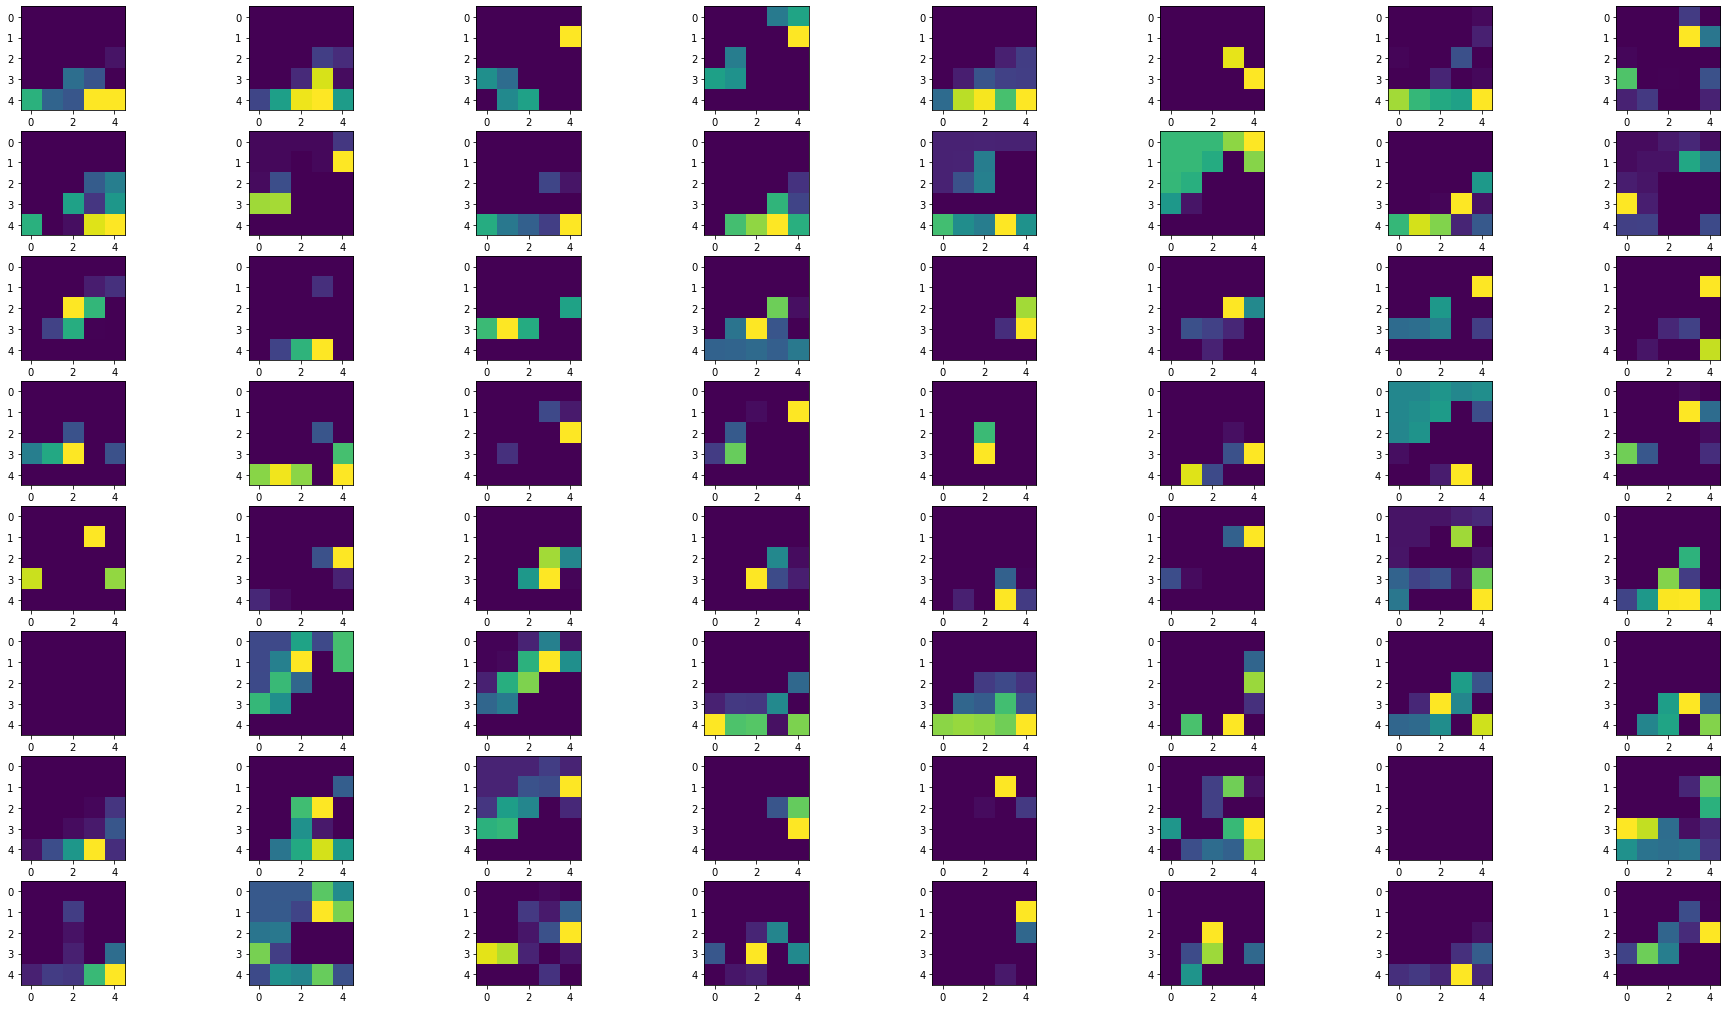

In [0]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

plt.rcParams["figure.figsize"] = [32,18]
#np.sqrt(len(CNN_final_layer_data))

for CONVOLUTION_NUMBER in range(64):
  plt.subplot(8,8,CONVOLUTION_NUMBER+1) 
  plt.imshow(CNN_final_layer_data[CONVOLUTION_NUMBER], cmap='viridis');

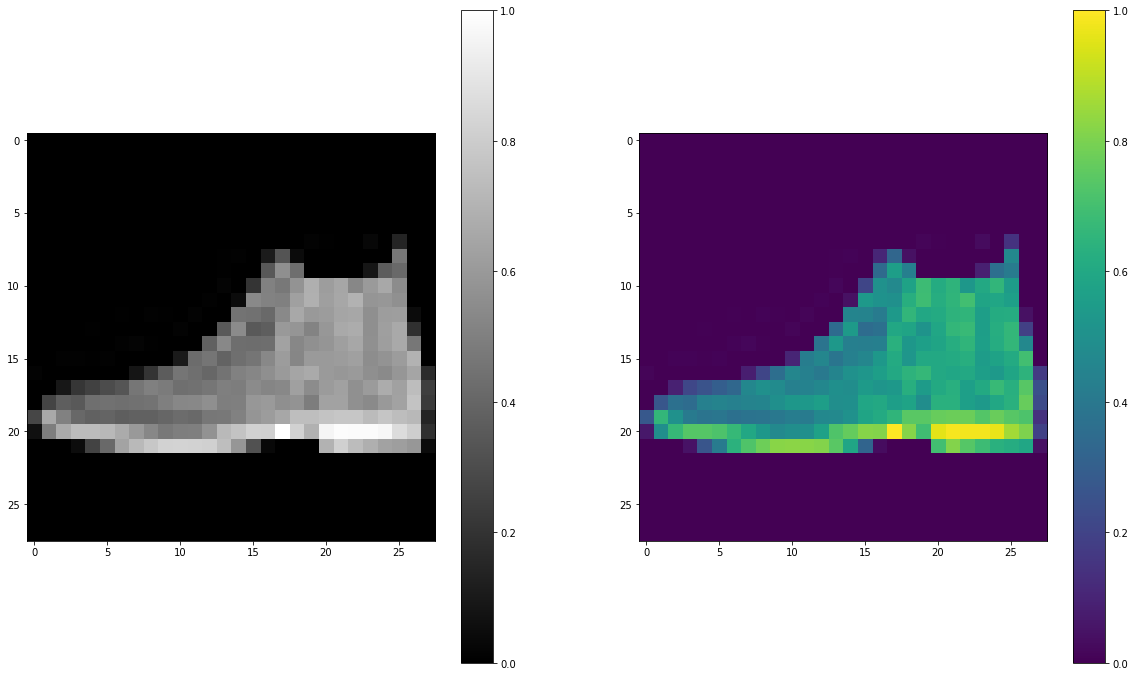

In [0]:
plt.figure(figsize=(64,12))

FIRST_IMAGE=0
image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
plt.colorbar();

# Visualizing all 64 Convolutions and Pooling - FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE

In [0]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

plt.rcParams["figure.figsize"] = [20,12]

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
#CONVOLUTION_NUMBER = 1 #0 to 63

CNN_final_layer_data_FIRST_IMAGE = []
CNN_final_layer_data_SECOND_IMAGE = []
CNN_final_layer_data_THIRD_IMAGE = []

for CONVOLUTION_NUMBER in range(64):
  f, axarr = plt.subplots(3,4)
  print('CONVOLUTION_NUMBER:',CONVOLUTION_NUMBER)

  for x in range(0,4):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axarr[0,x].grid(False)
    
    f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axarr[1,x].grid(False)

    f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axarr[2,x].grid(False)

  CNN_final_layer_data_FIRST_IMAGE.append(f1[0, : , :, CONVOLUTION_NUMBER])
  CNN_final_layer_data_SECOND_IMAGE.append(f2[0, : , :, CONVOLUTION_NUMBER])
  CNN_final_layer_data_THIRD_IMAGE.append(f3[0, : , :, CONVOLUTION_NUMBER])
  plt.show()  

# Visualizing all 64 Pooling Layers - FIRST_IMAGE

In [0]:
print(len(CNN_final_layer_data_FIRST_IMAGE), len(CNN_final_layer_data_SECOND_IMAGE), len(CNN_final_layer_data_THIRD_IMAGE))

64 64 64


<IPython.core.display.Javascript object>

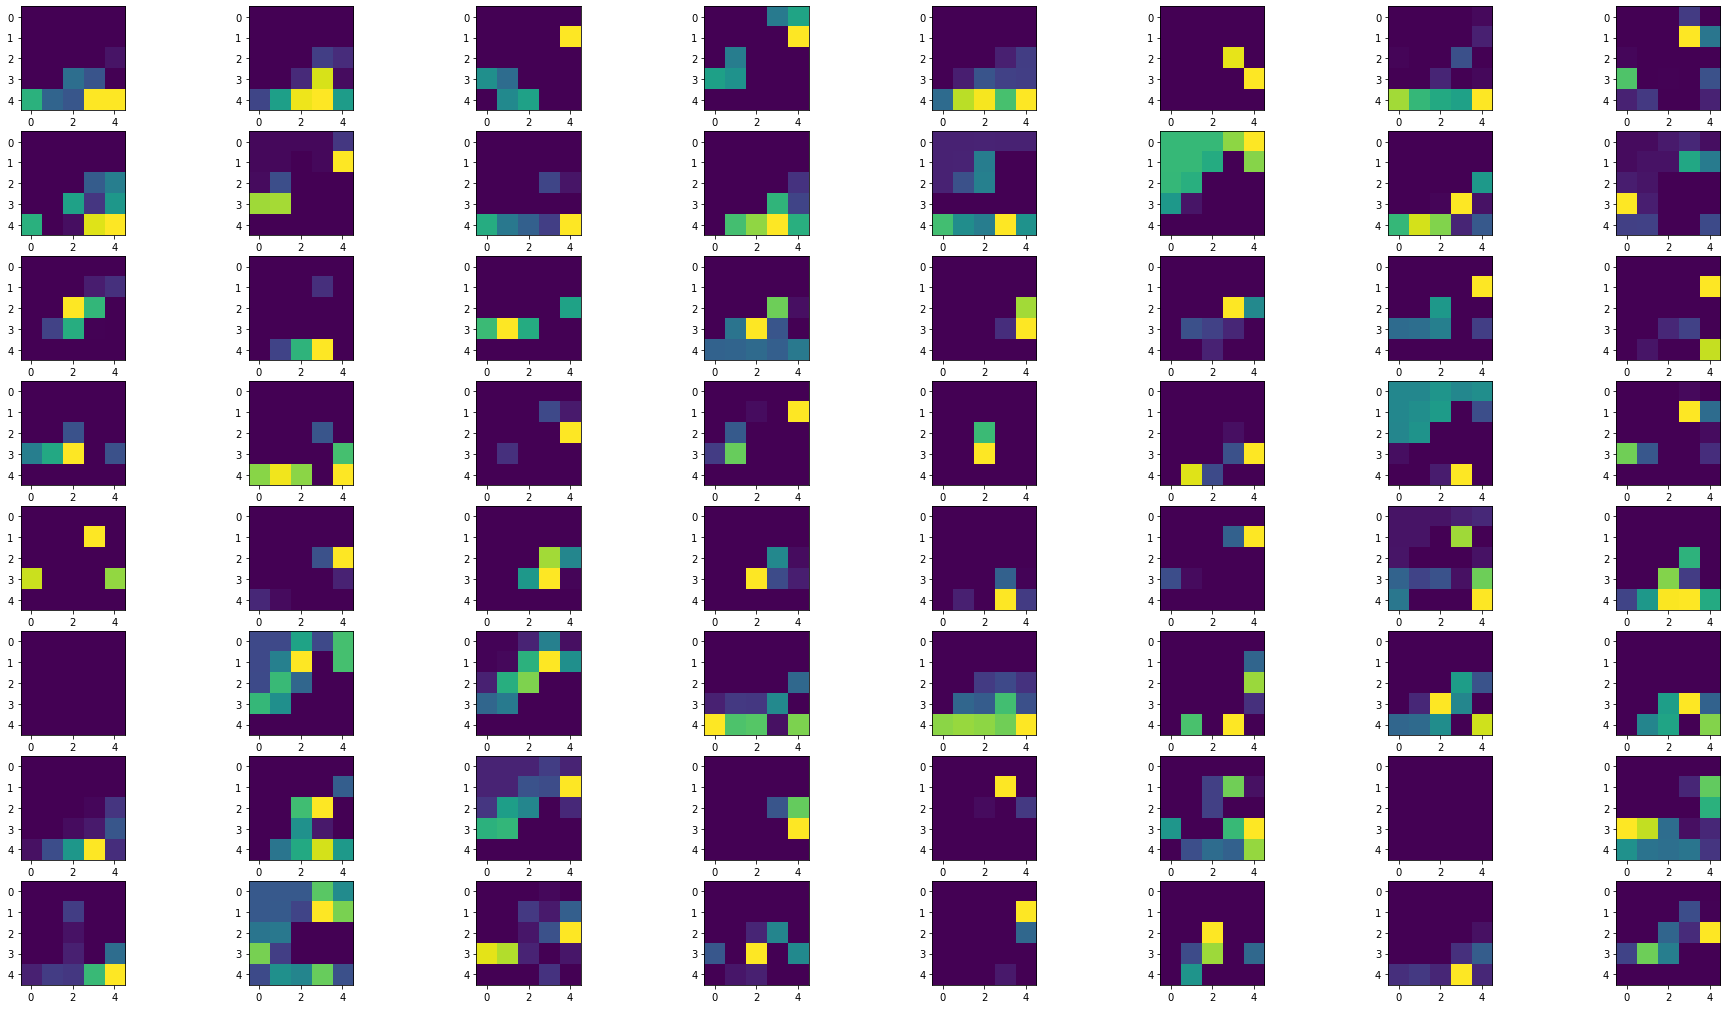

In [0]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

plt.rcParams["figure.figsize"] = [32,18]

for CONVOLUTION_NUMBER in range(64):
  plt.subplot(8,8,CONVOLUTION_NUMBER+1) 
  plt.imshow(CNN_final_layer_data_FIRST_IMAGE[CONVOLUTION_NUMBER], cmap='viridis');

# Visualizing all 64 Pooling Layers - SECOND_IMAGE

<IPython.core.display.Javascript object>

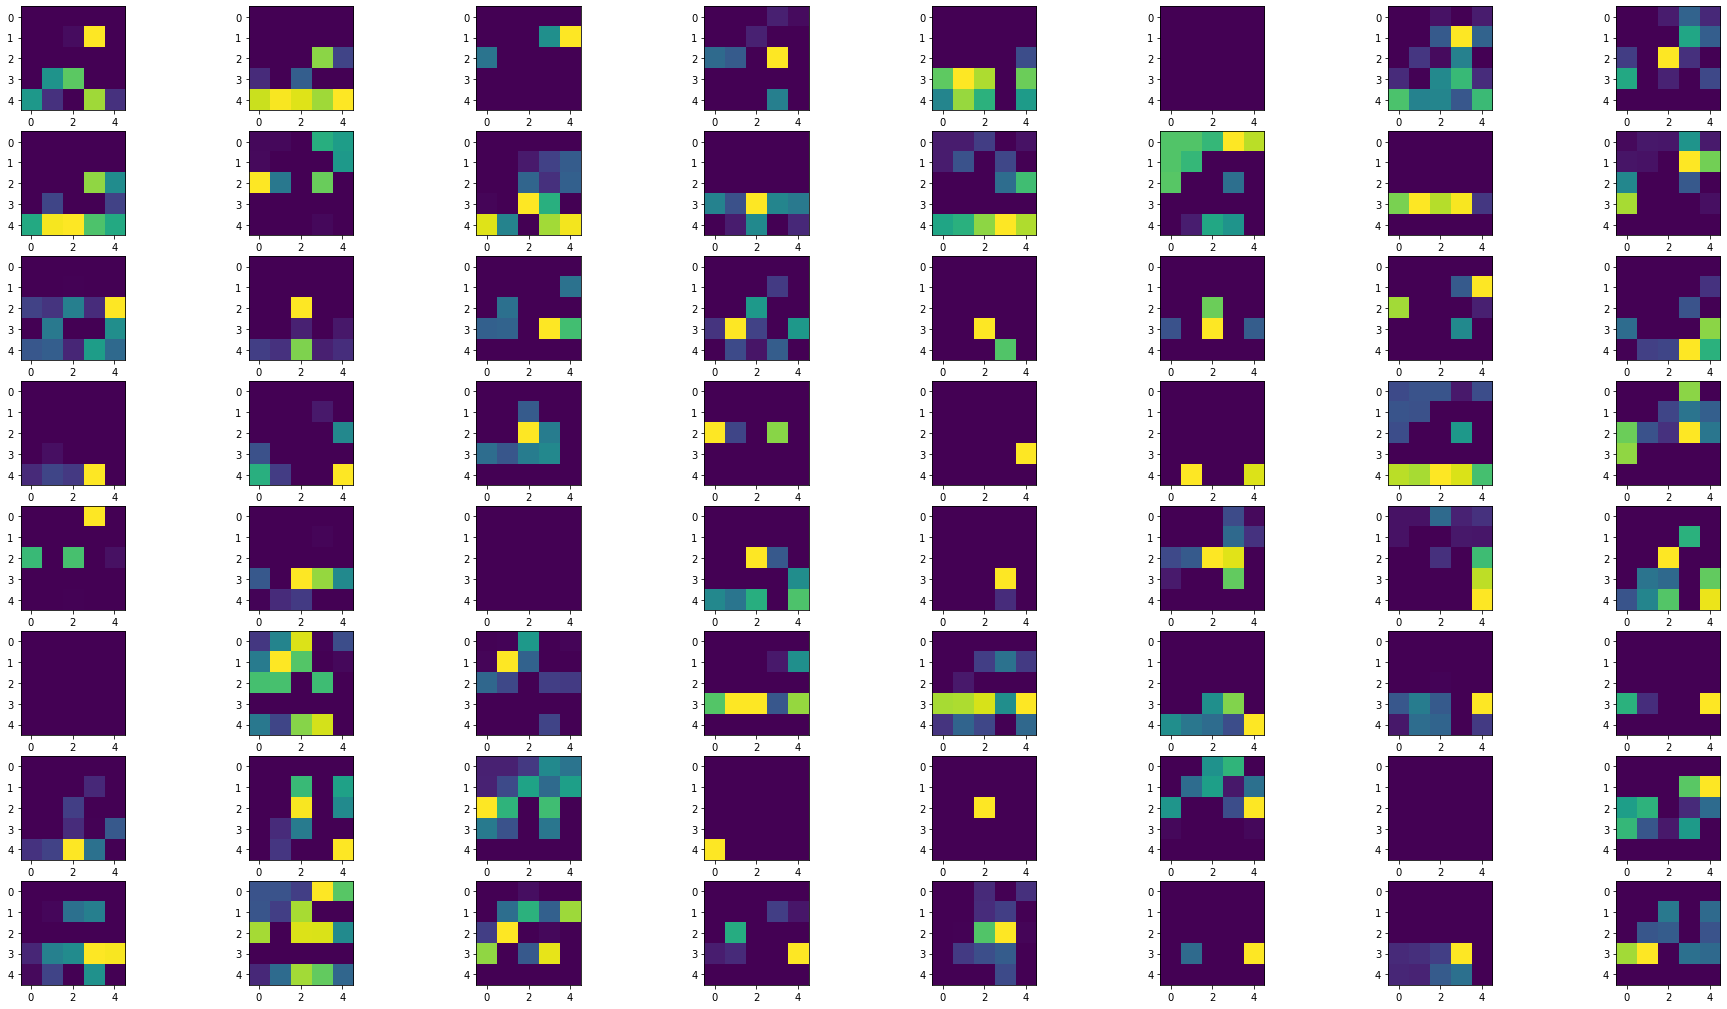

In [0]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

plt.rcParams["figure.figsize"] = [32,18]

for CONVOLUTION_NUMBER in range(64):
  plt.subplot(8,8,CONVOLUTION_NUMBER+1) 
  plt.imshow(CNN_final_layer_data_SECOND_IMAGE[CONVOLUTION_NUMBER], cmap='viridis');

# Visualizing all 64 Pooling Layers - THIRD_IMAGE

<IPython.core.display.Javascript object>

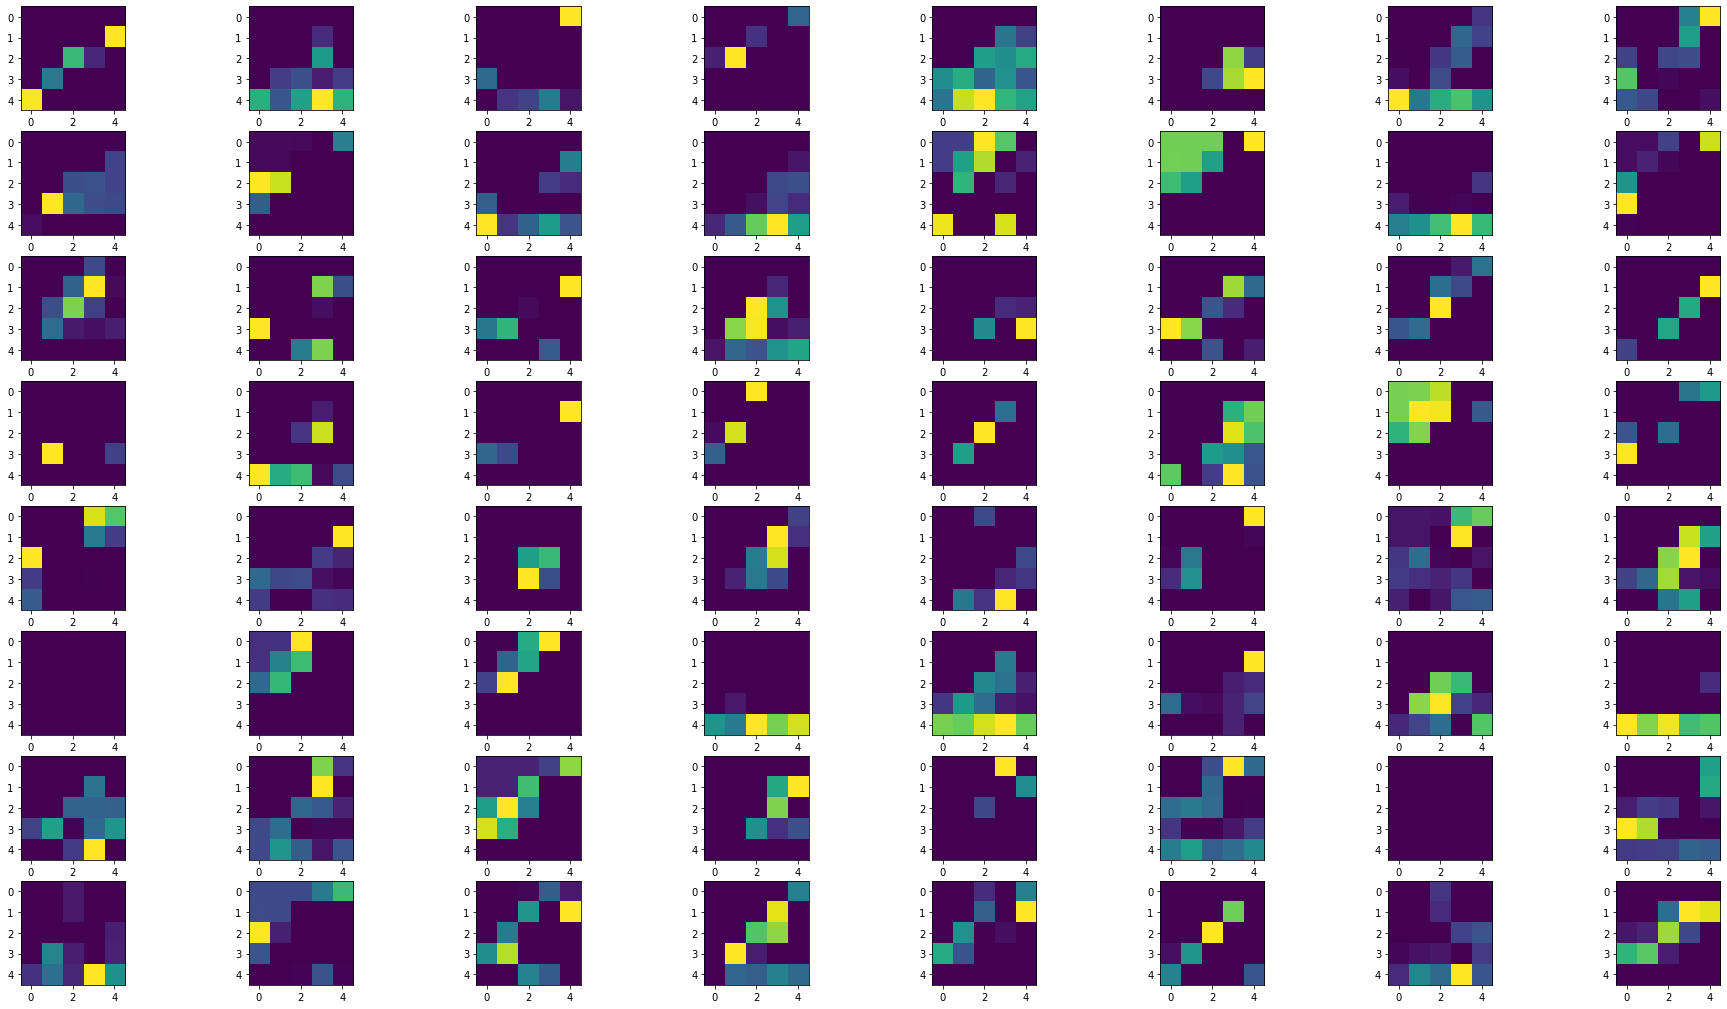

In [0]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

plt.rcParams["figure.figsize"] = [32,18]

for CONVOLUTION_NUMBER in range(64):
  plt.subplot(8,8,CONVOLUTION_NUMBER+1) 
  plt.imshow(CNN_final_layer_data_THIRD_IMAGE[CONVOLUTION_NUMBER], cmap='viridis');

# Putting it all together with 1 row for each image - Visualizing all 64 Pooling Layers
FIRST_IMAGE   8 layers  
SECOND_IMAGE  8 layers  
THIRD_IMAGE   8 layers  

<IPython.core.display.Javascript object>

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 0 /8


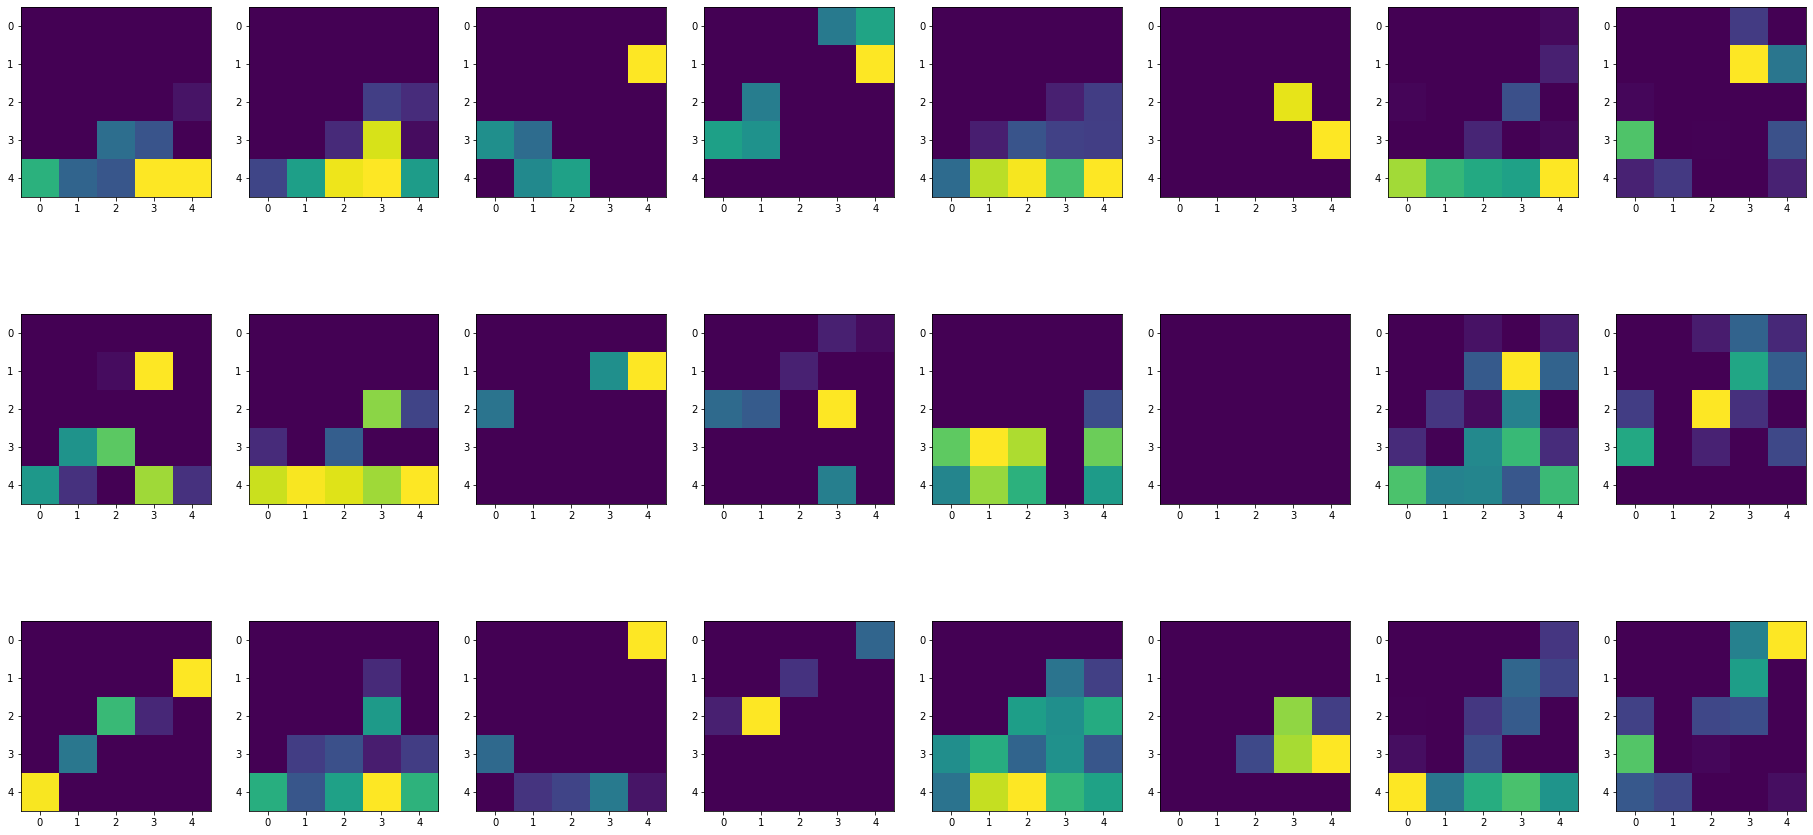

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 1 /8


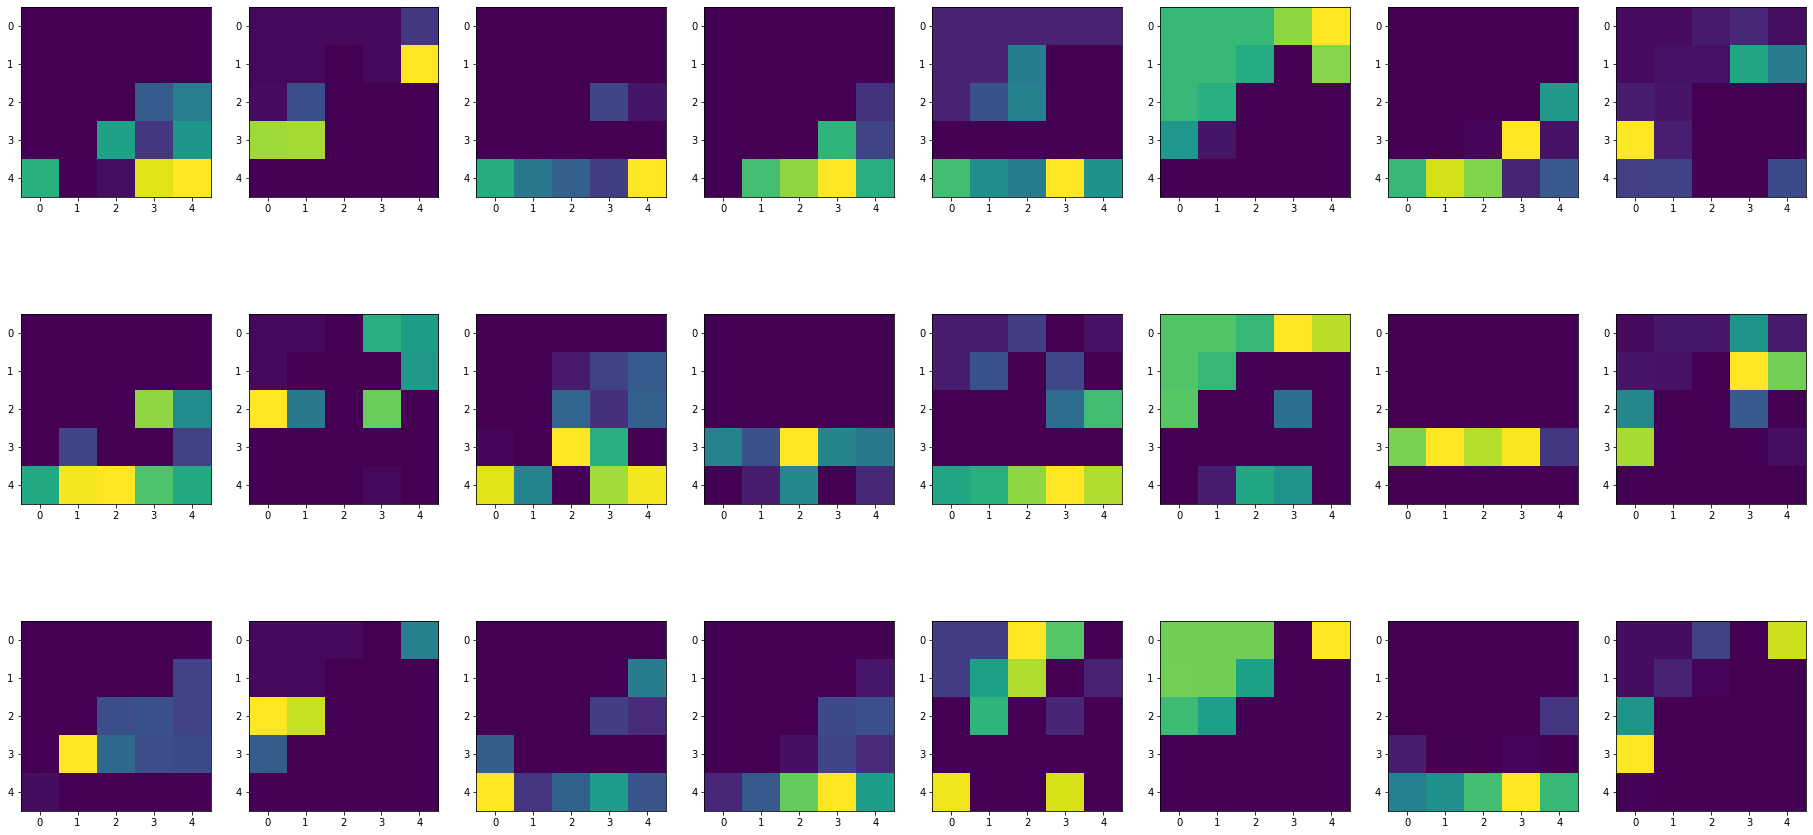

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 2 /8


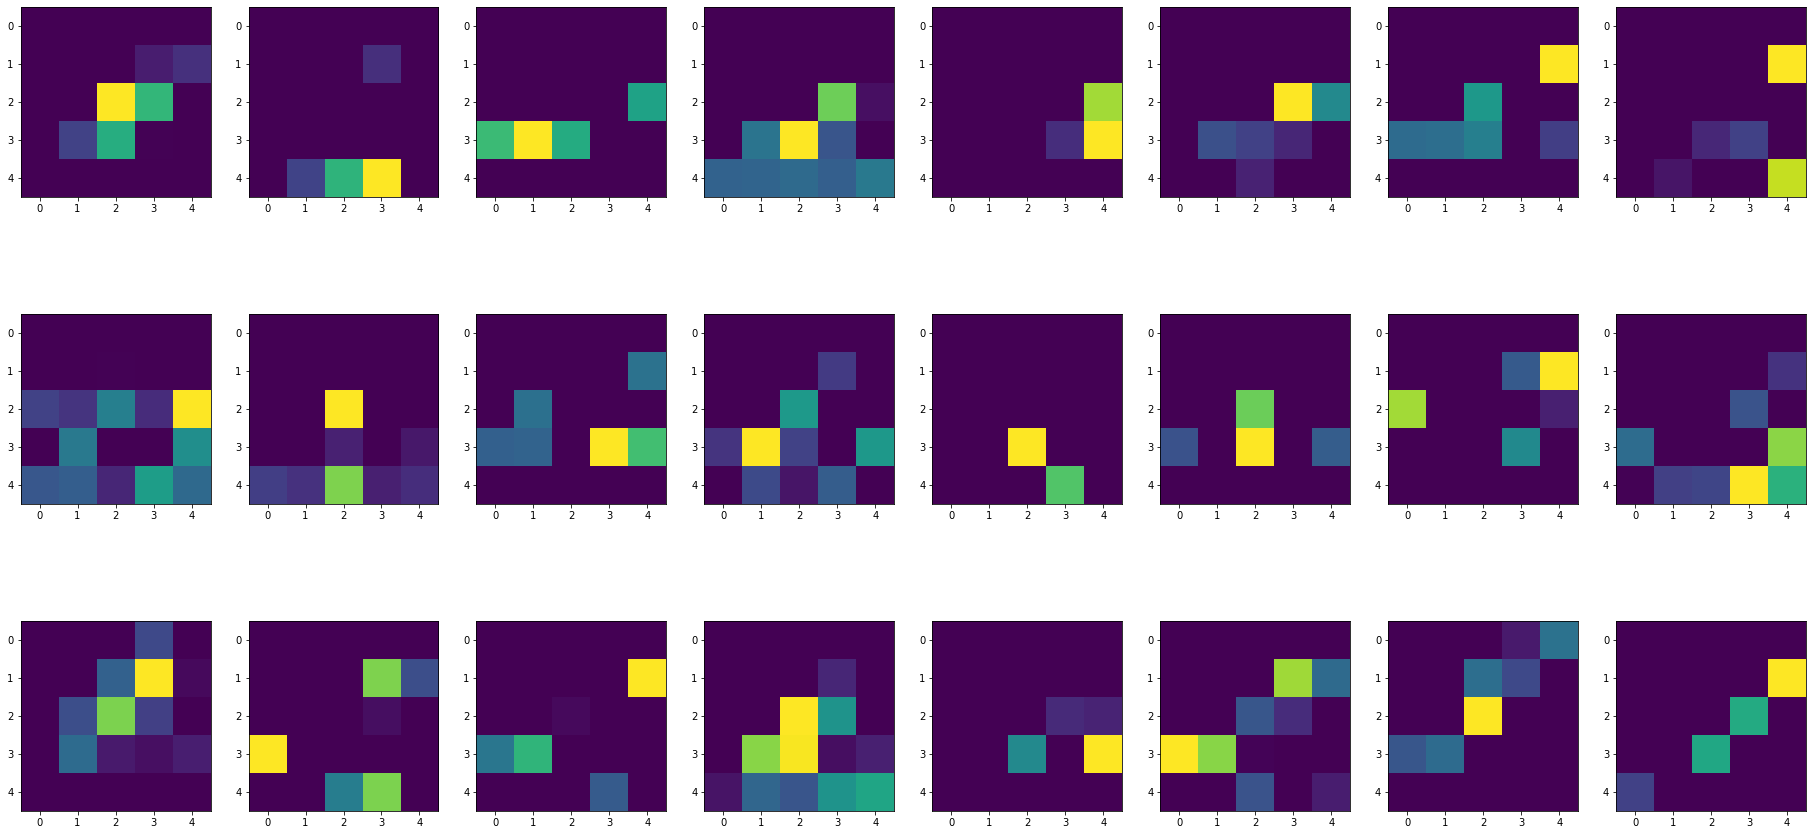

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 3 /8


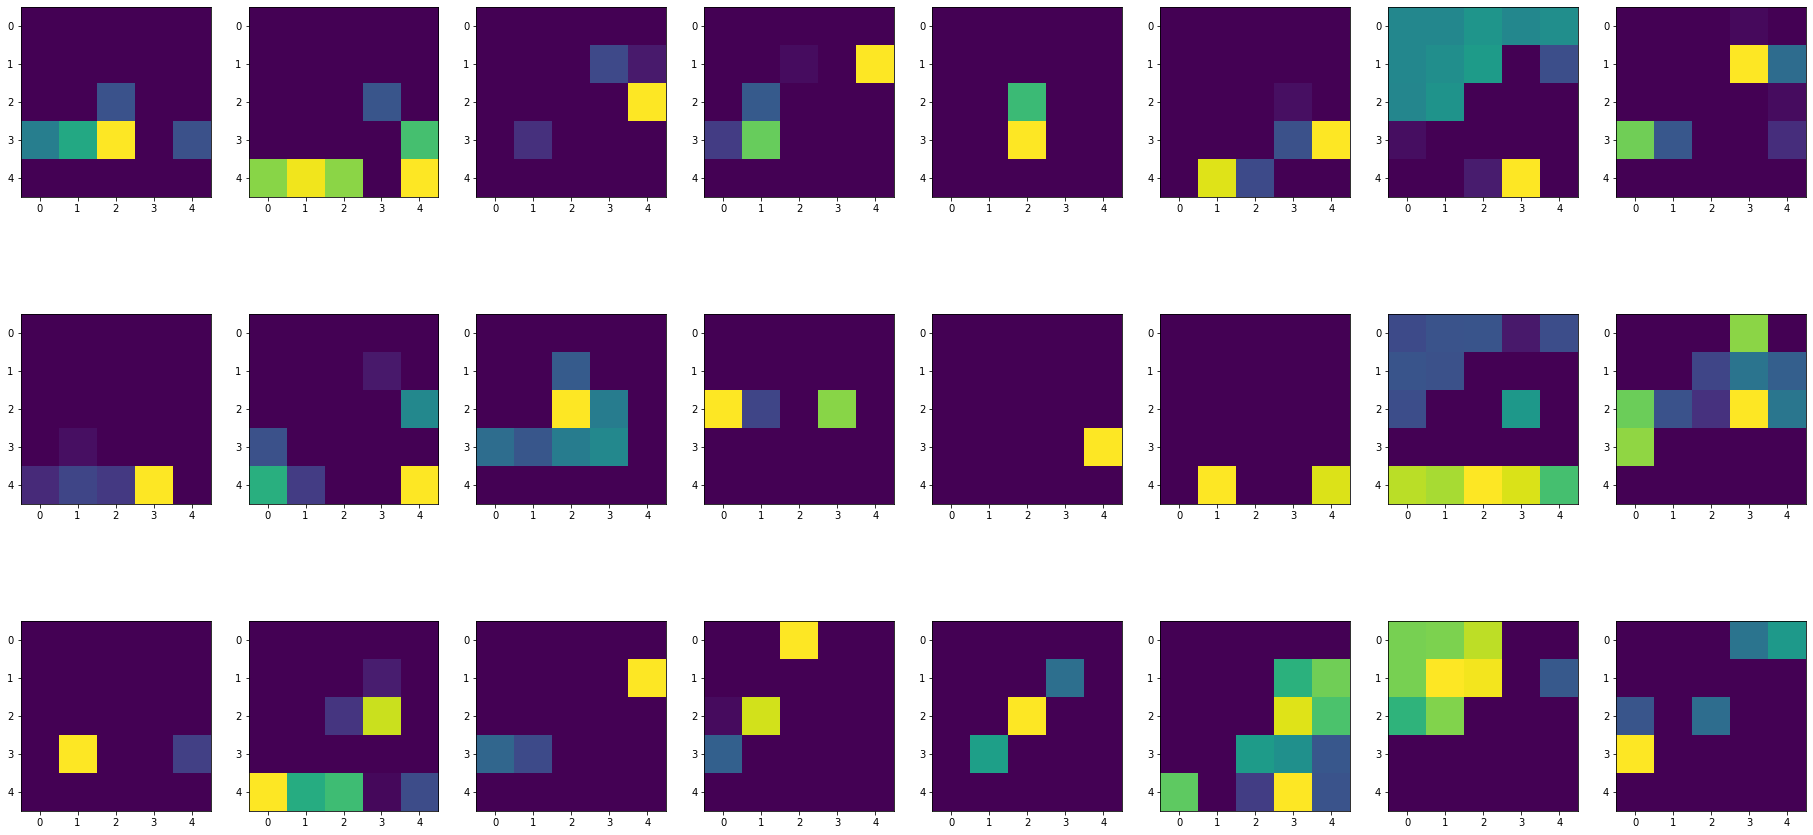

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 4 /8


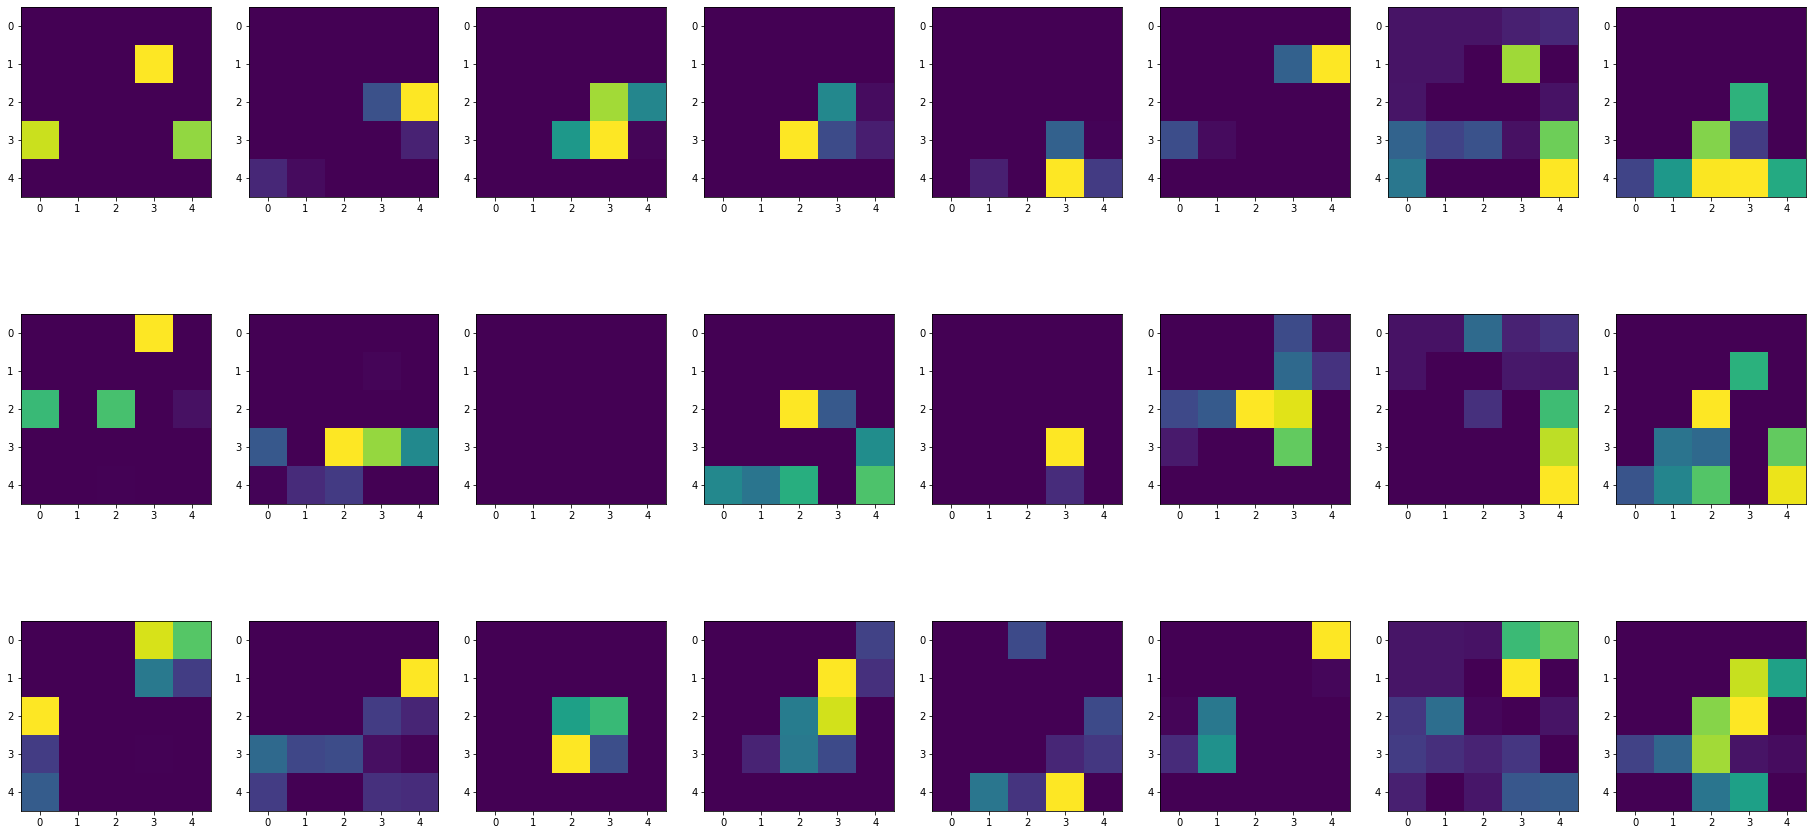

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 5 /8


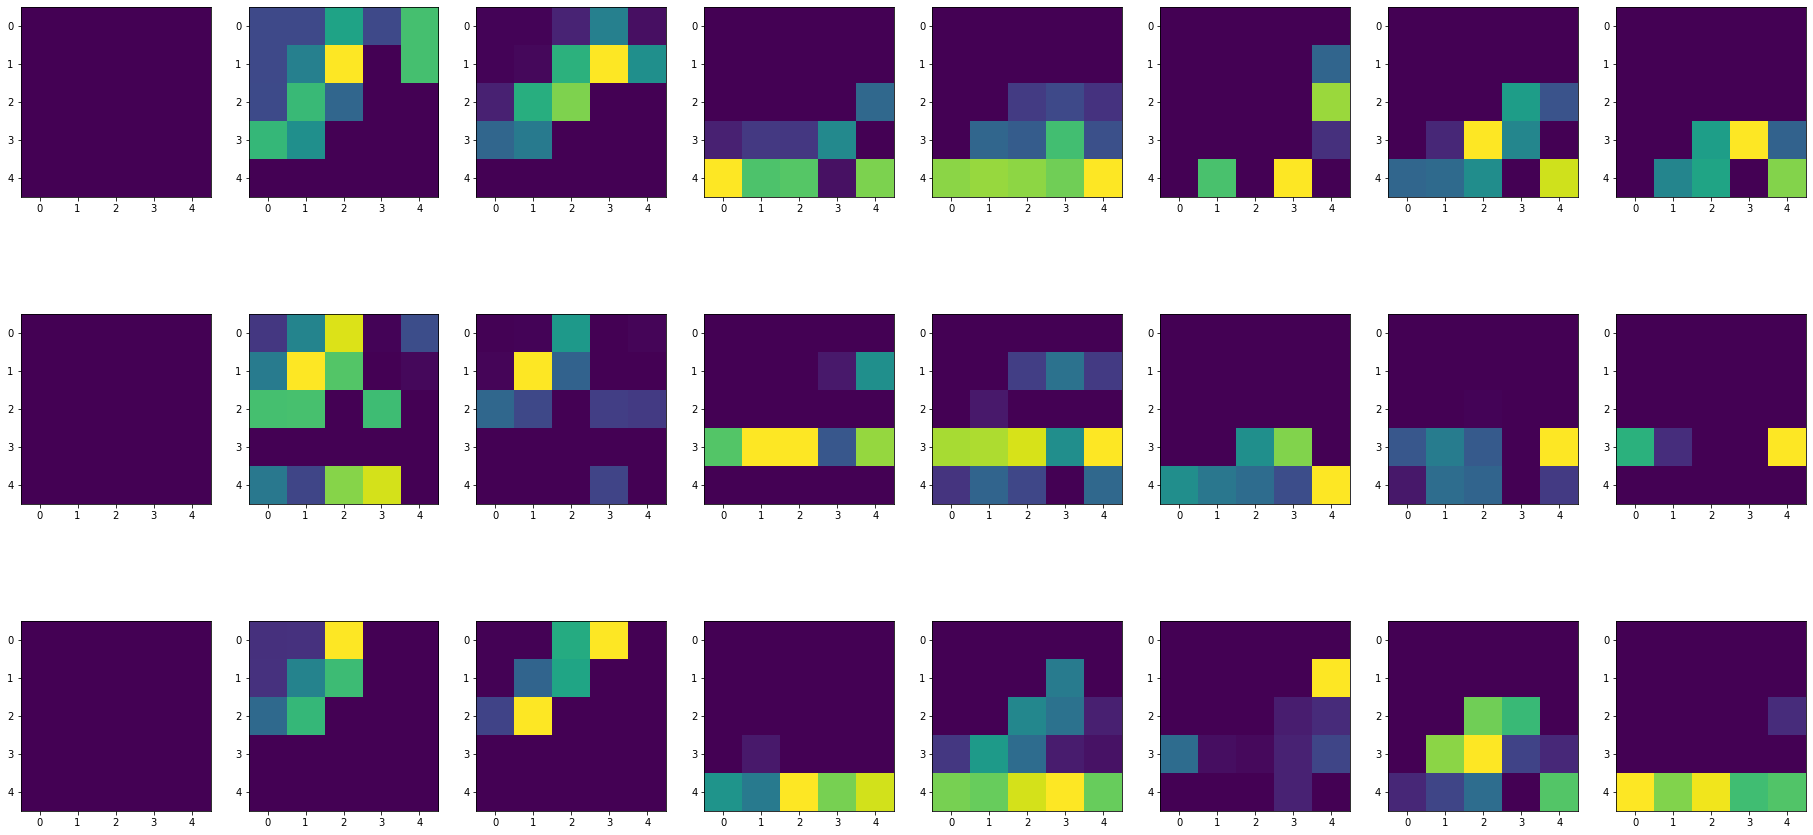

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 6 /8


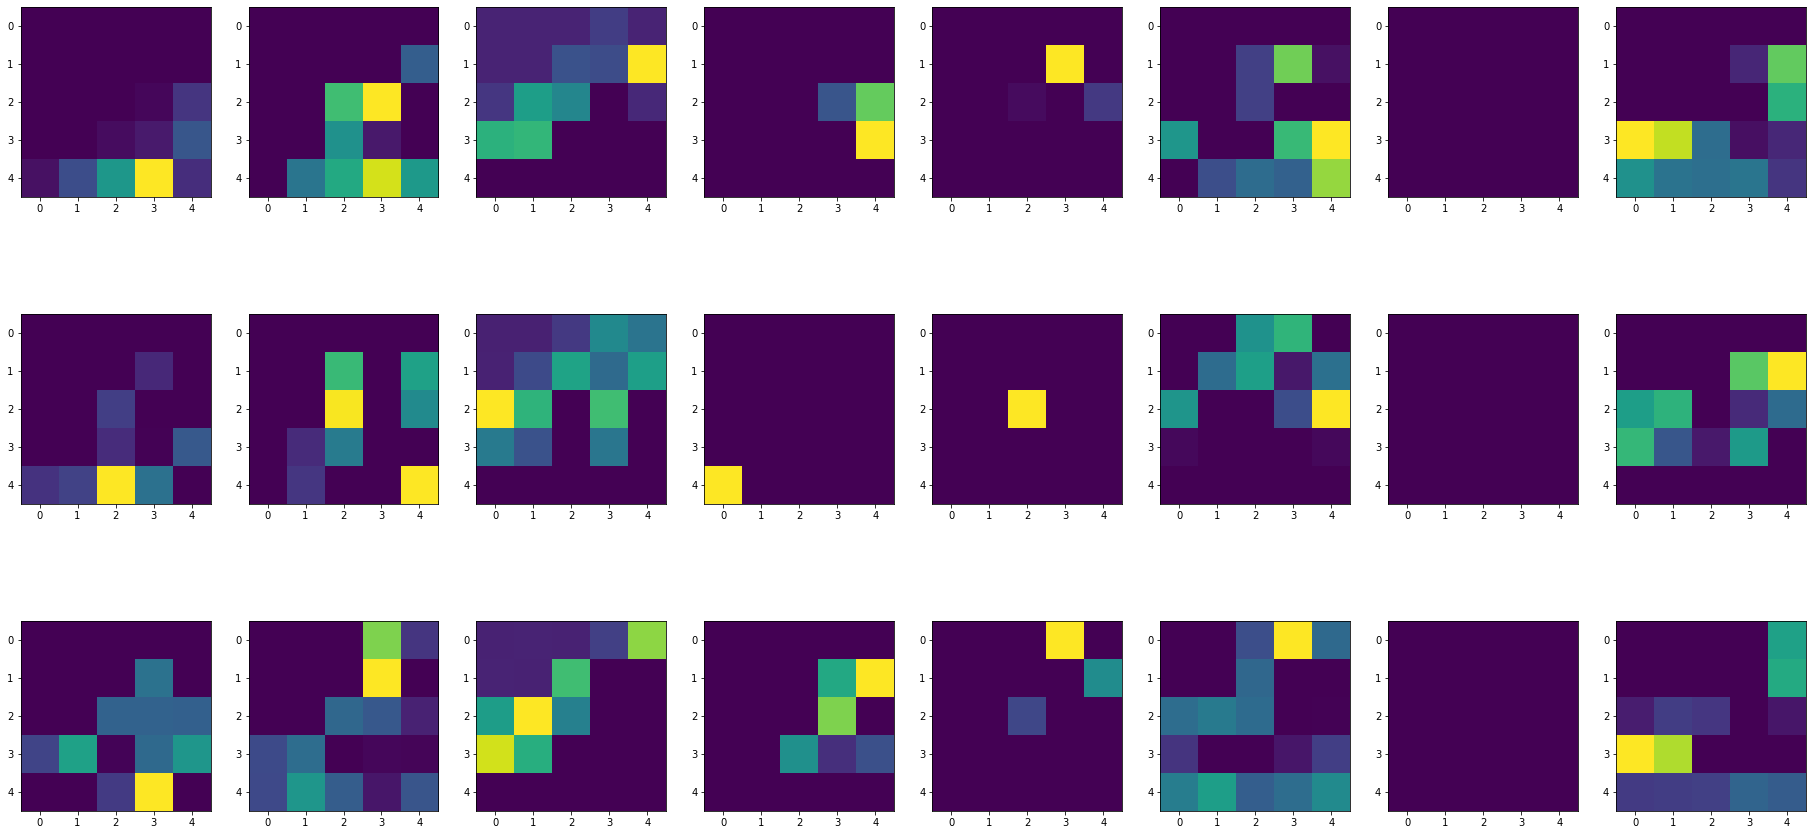

FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row: 7 /8


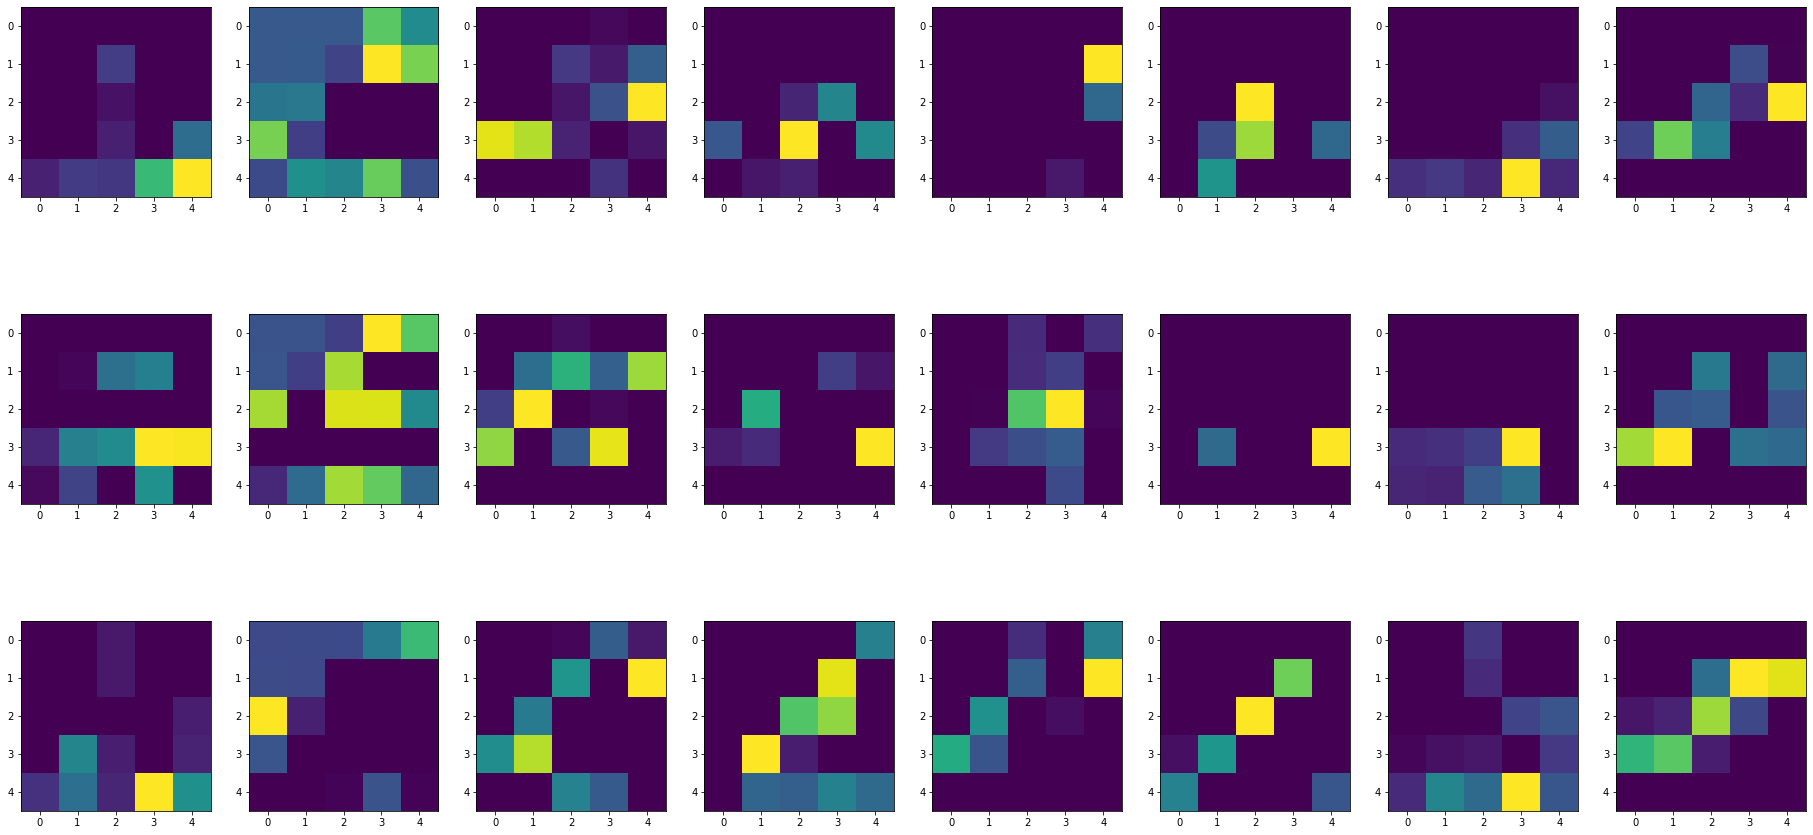

In [0]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

plt.rcParams["figure.figsize"] = [32,16]

for row in range(8):
  print('FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE row:', row, '/8')

  f, axarr = plt.subplots(3,8)
  for CONVOLUTION_NUMBER in range(8):
    axarr[0,CONVOLUTION_NUMBER].imshow(CNN_final_layer_data_FIRST_IMAGE[row*8 + CONVOLUTION_NUMBER], cmap='viridis');
    axarr[1,CONVOLUTION_NUMBER].imshow(CNN_final_layer_data_SECOND_IMAGE[row*8 + CONVOLUTION_NUMBER], cmap='viridis');
    axarr[2,CONVOLUTION_NUMBER].imshow(CNN_final_layer_data_THIRD_IMAGE[row*8 + CONVOLUTION_NUMBER], cmap='viridis');
  plt.show()   

# Fashion-MNIST labels
https://github.com/zalandoresearch/fashion-mnist

Each training and test example is assigned to one of the following labels:  

Label	Description  
*   0	T-shirt/top  
*   1	Trouser  
*   2	Pullover  
*   3	Dress  
*   4	Coat  
*   5	Sandal  
*   6	Shirt  
*   7	Sneaker  
*   8	Bag  
*   9	Ankle boot  

In [0]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


## Let's look at 3 samples of label 0: T-shirt/top

In [0]:
import numpy as np
np.where(test_labels[:100]==0)

(array([19, 27, 35, 59, 71, 85, 88, 96]),)

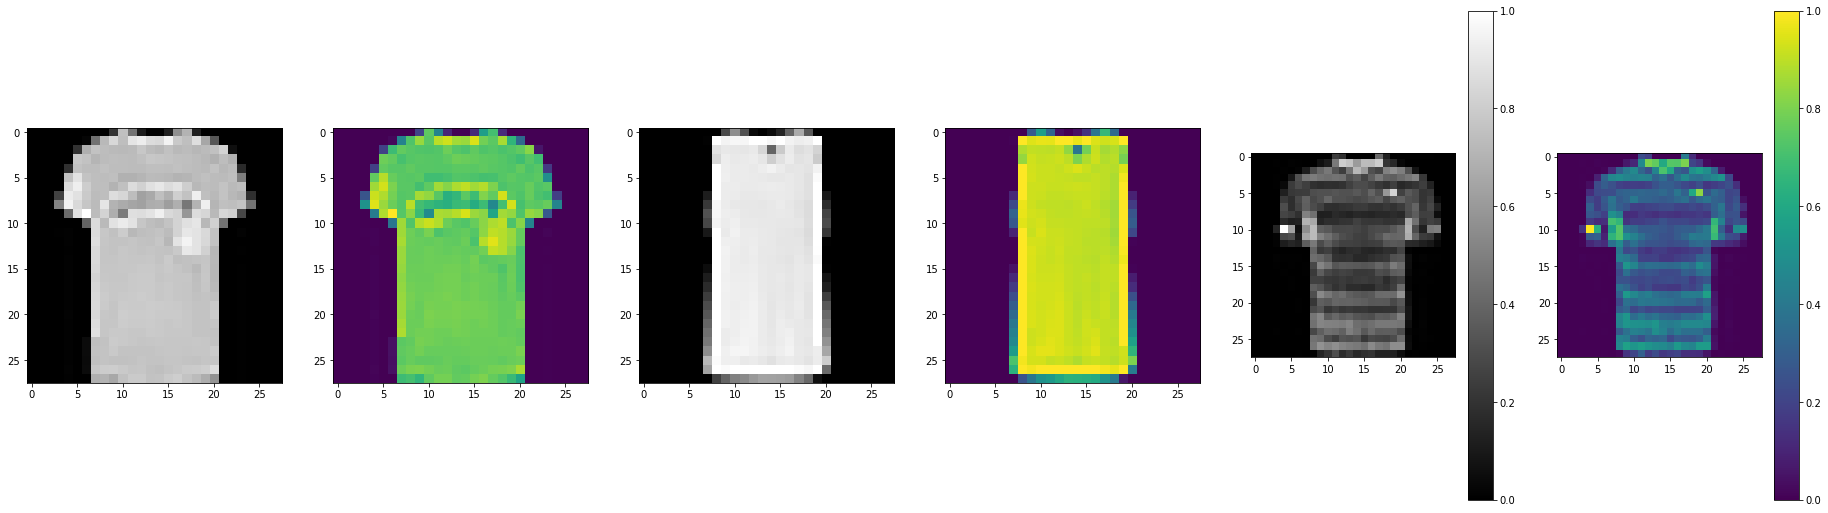

In [0]:
FIRST_IMAGE=19
SECOND_IMAGE=27
THIRD_IMAGE=35

plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 0: T-shirt/top after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

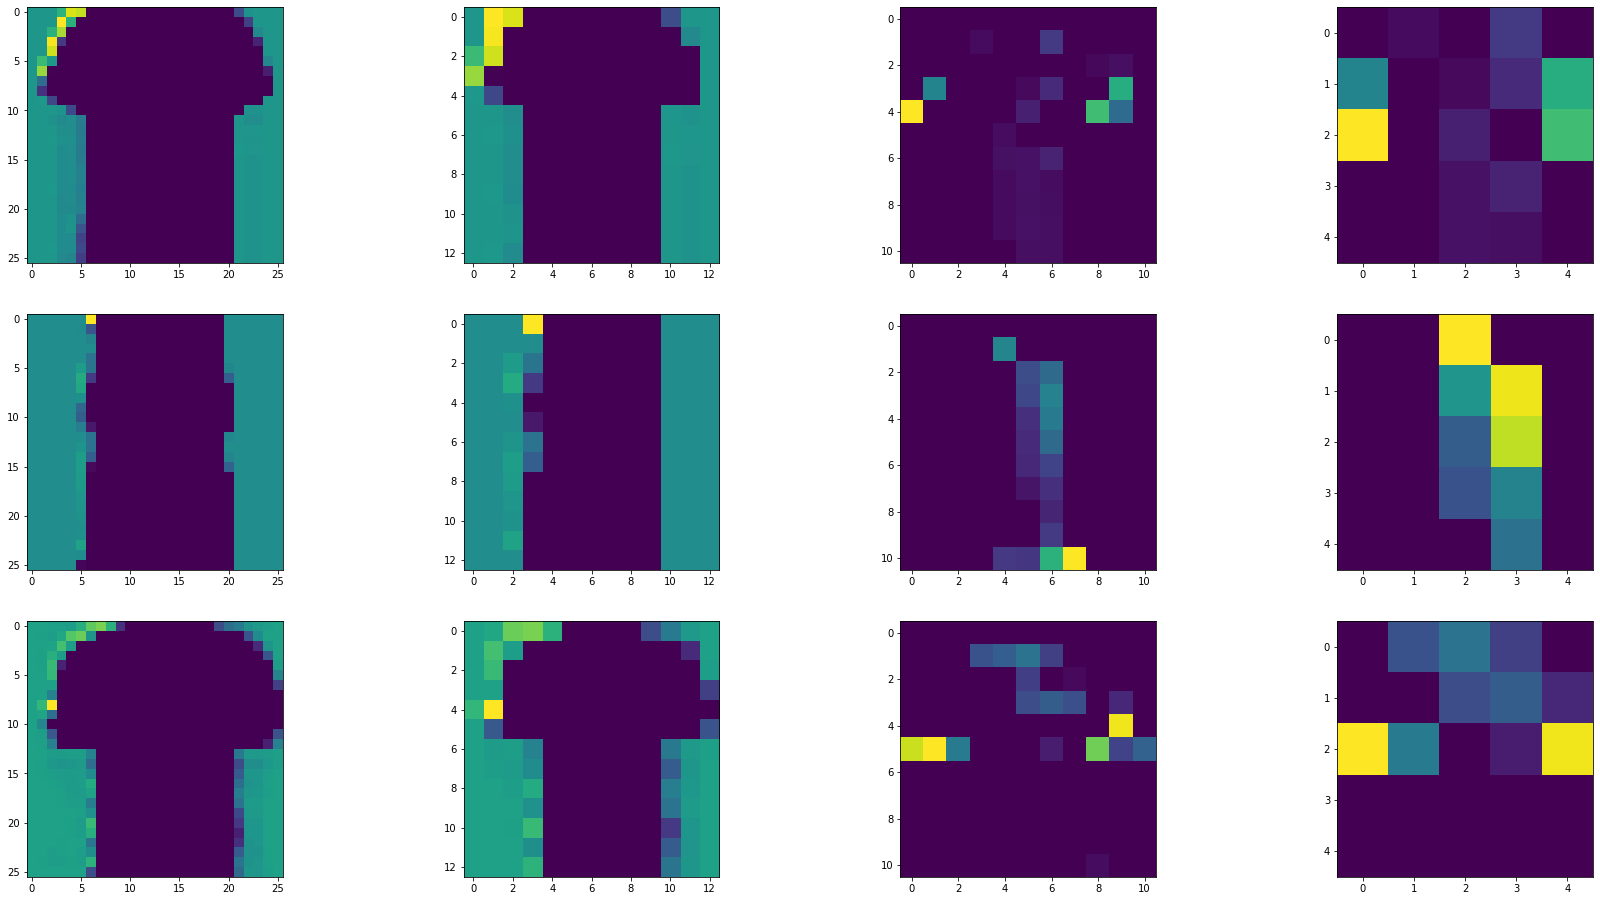

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 1: Trouser

In [0]:
label_index = np.where(test_labels[:100]==1)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 2,  3,  5, 15, 24, 41, 47, 64, 65, 76, 80, 94, 97])

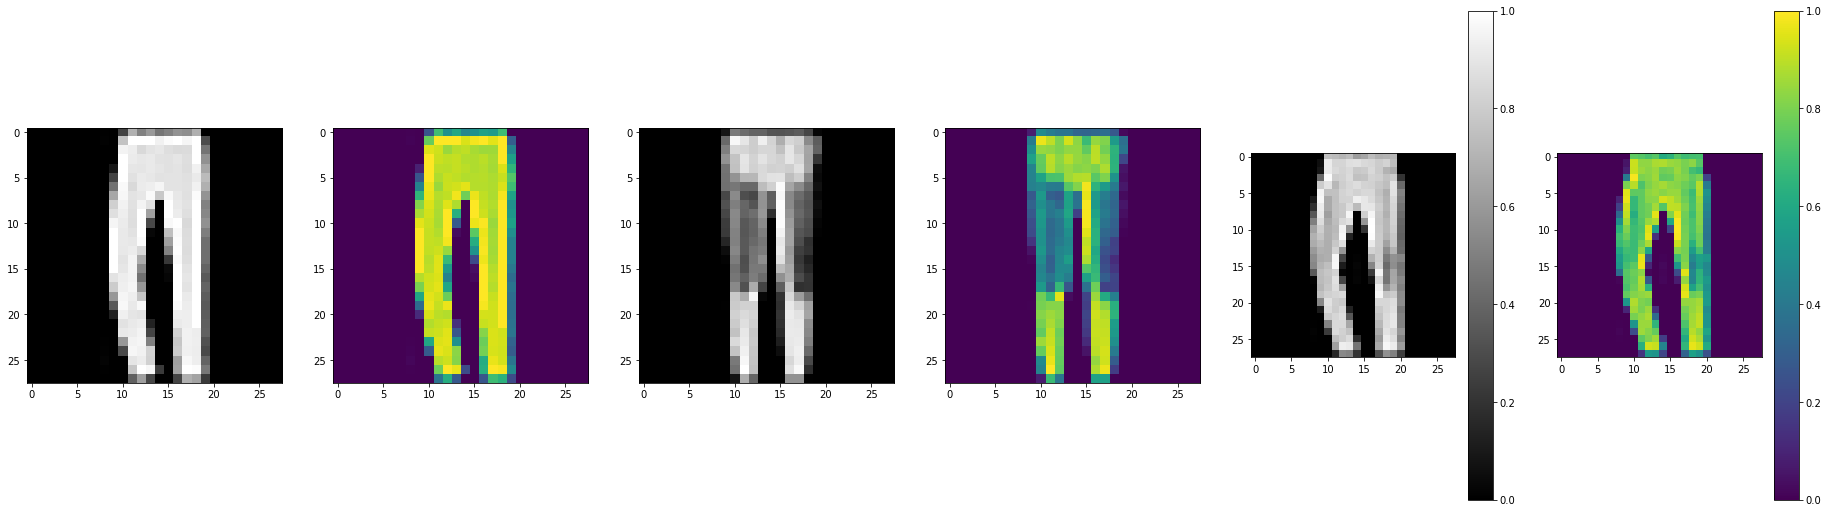

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 1: Trouser after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

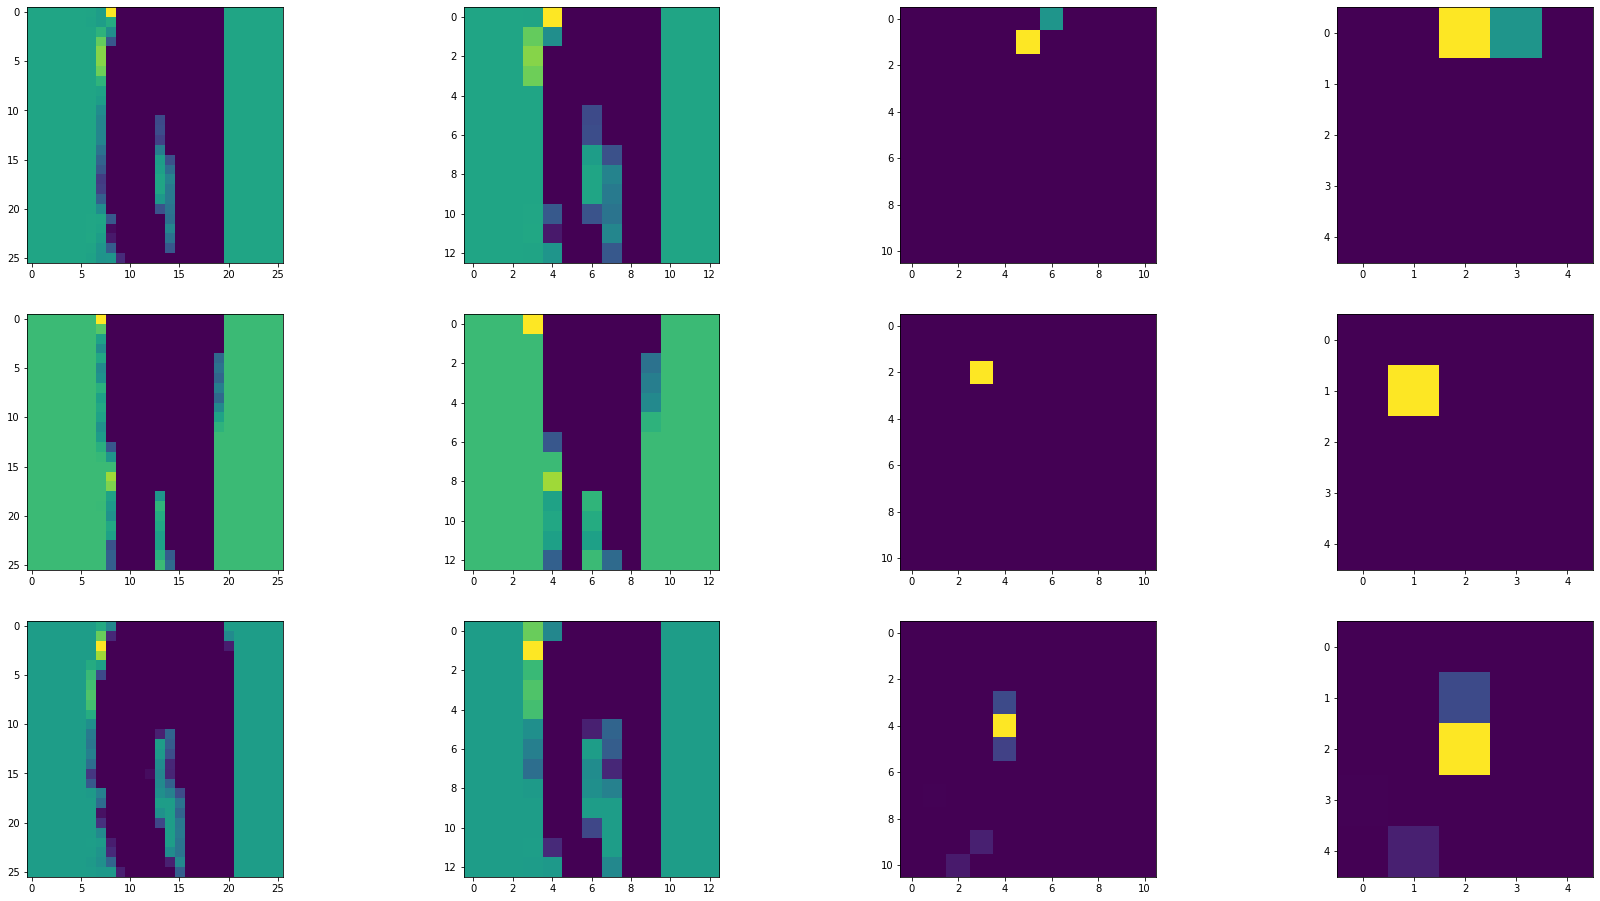

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 2: Pullover

In [0]:
label_index = np.where(test_labels[:100]==2)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 1, 16, 20, 46, 48, 49, 54, 55, 66, 72, 74, 77, 87, 99])

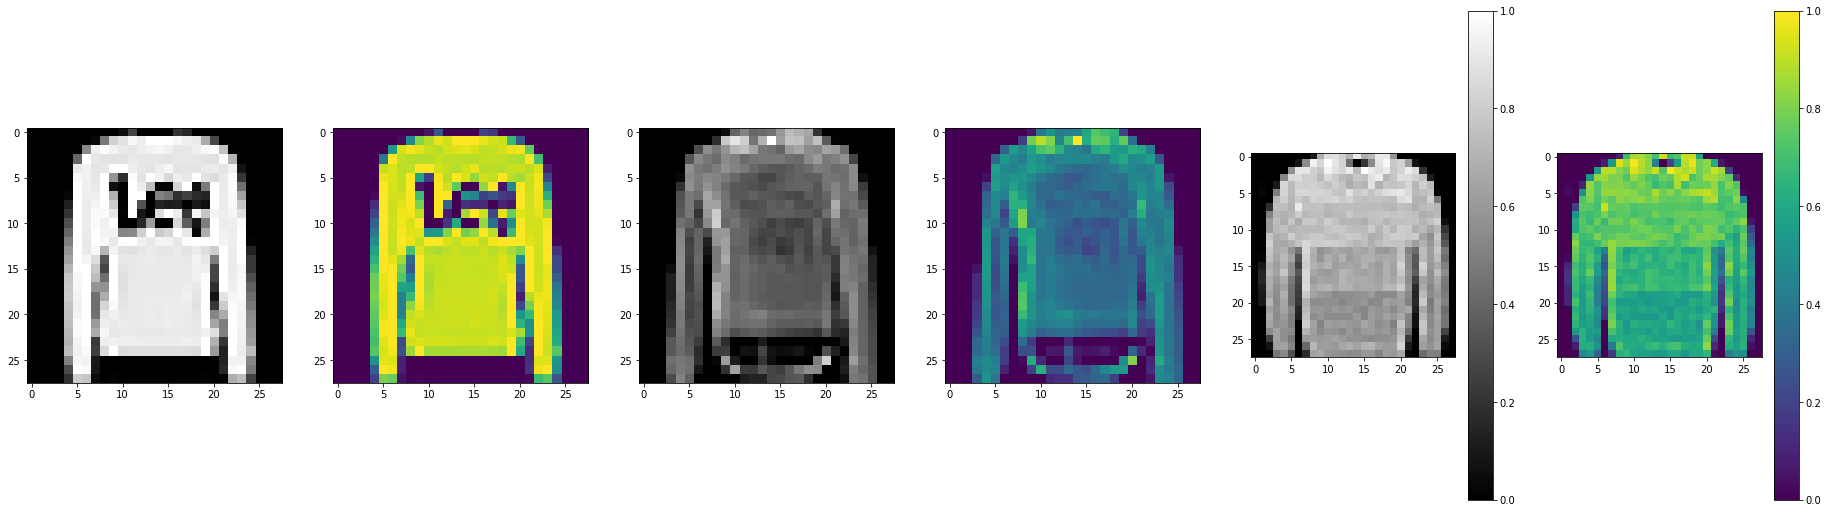

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 2: Pullover after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

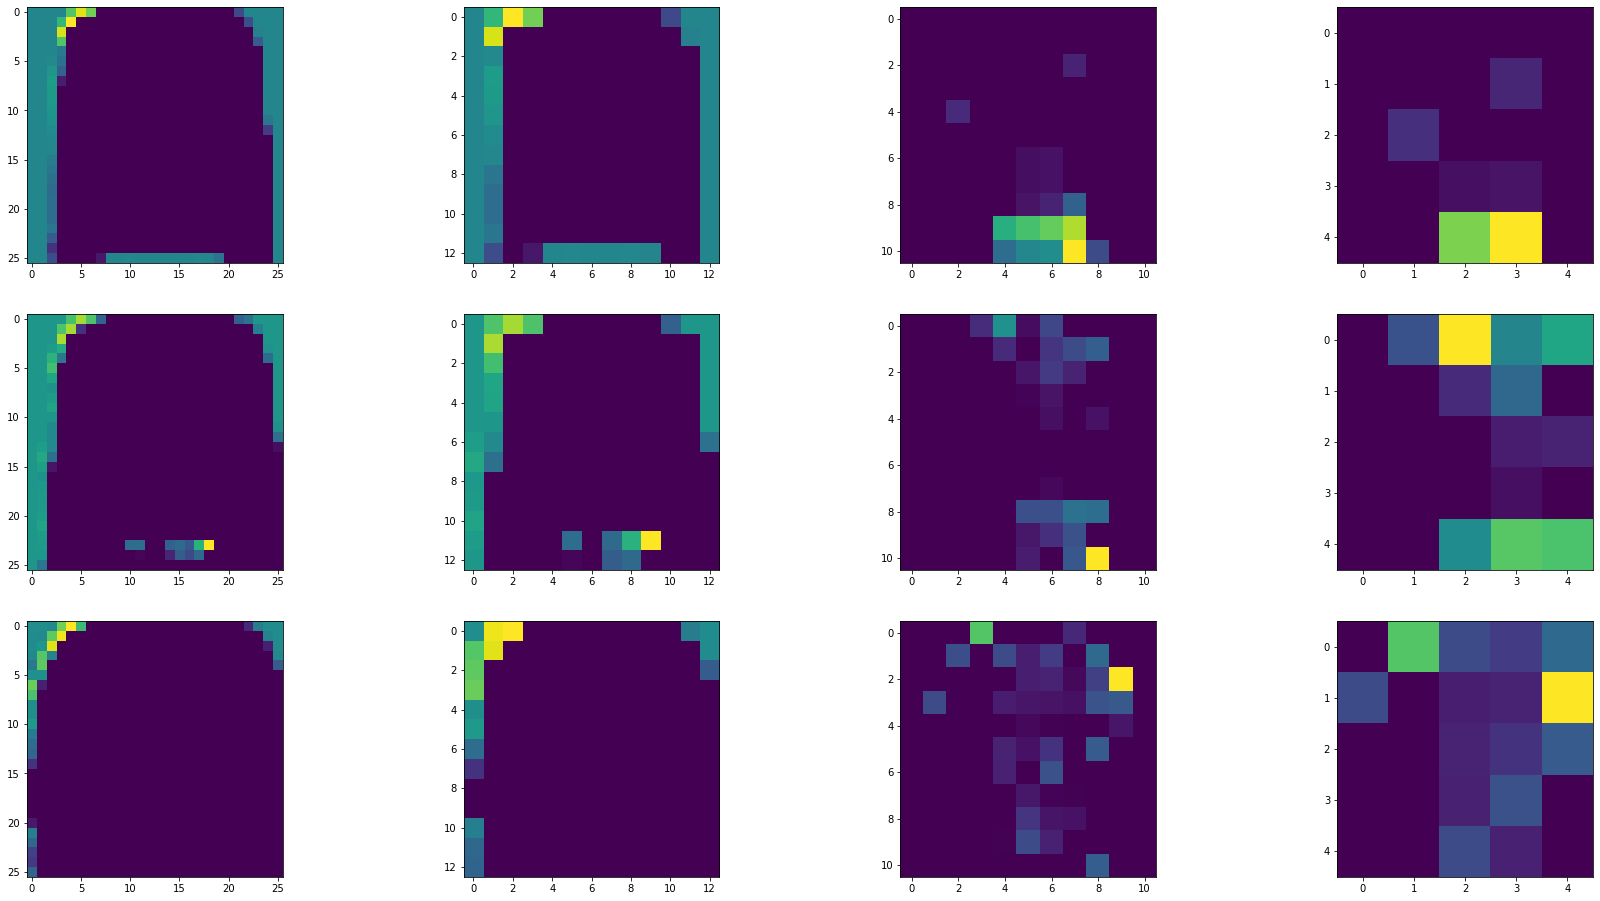

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 3: Dress

In [0]:
label_index = np.where(test_labels[:100]==3)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([13, 29, 32, 33, 42, 67, 75, 86, 91])

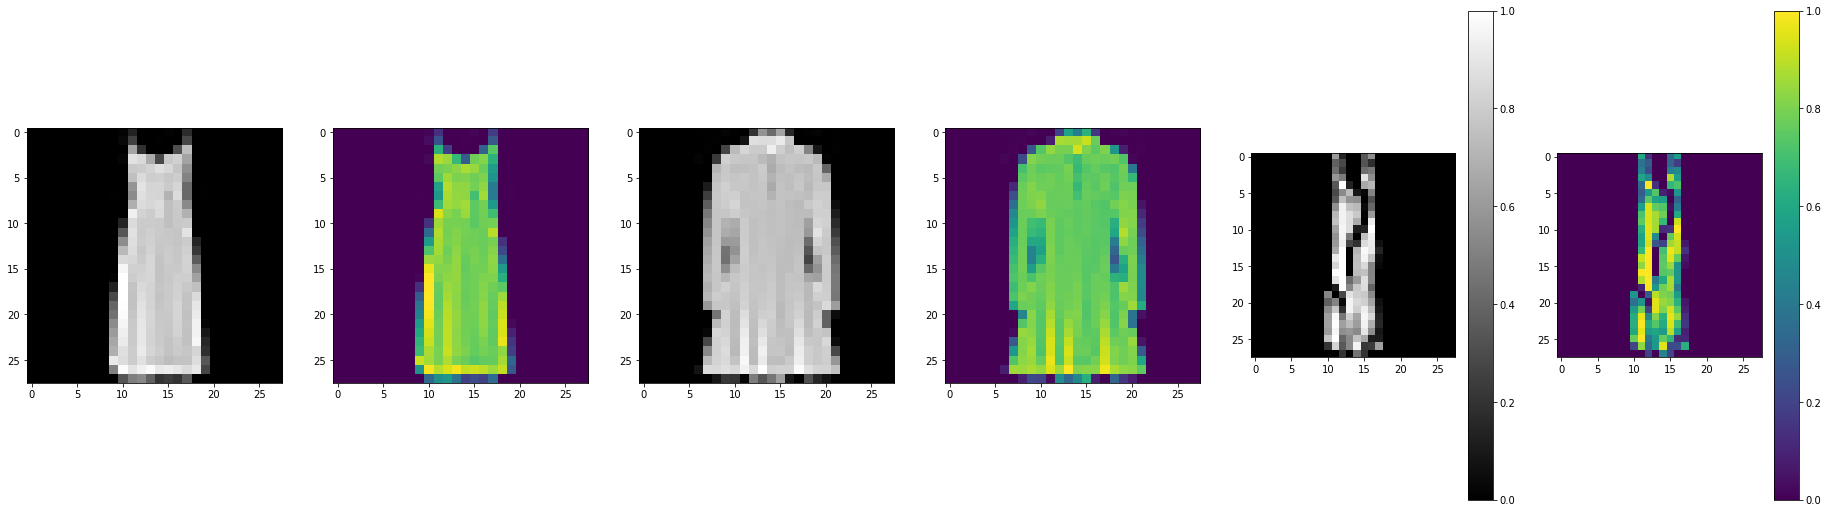

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 3: Dress after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

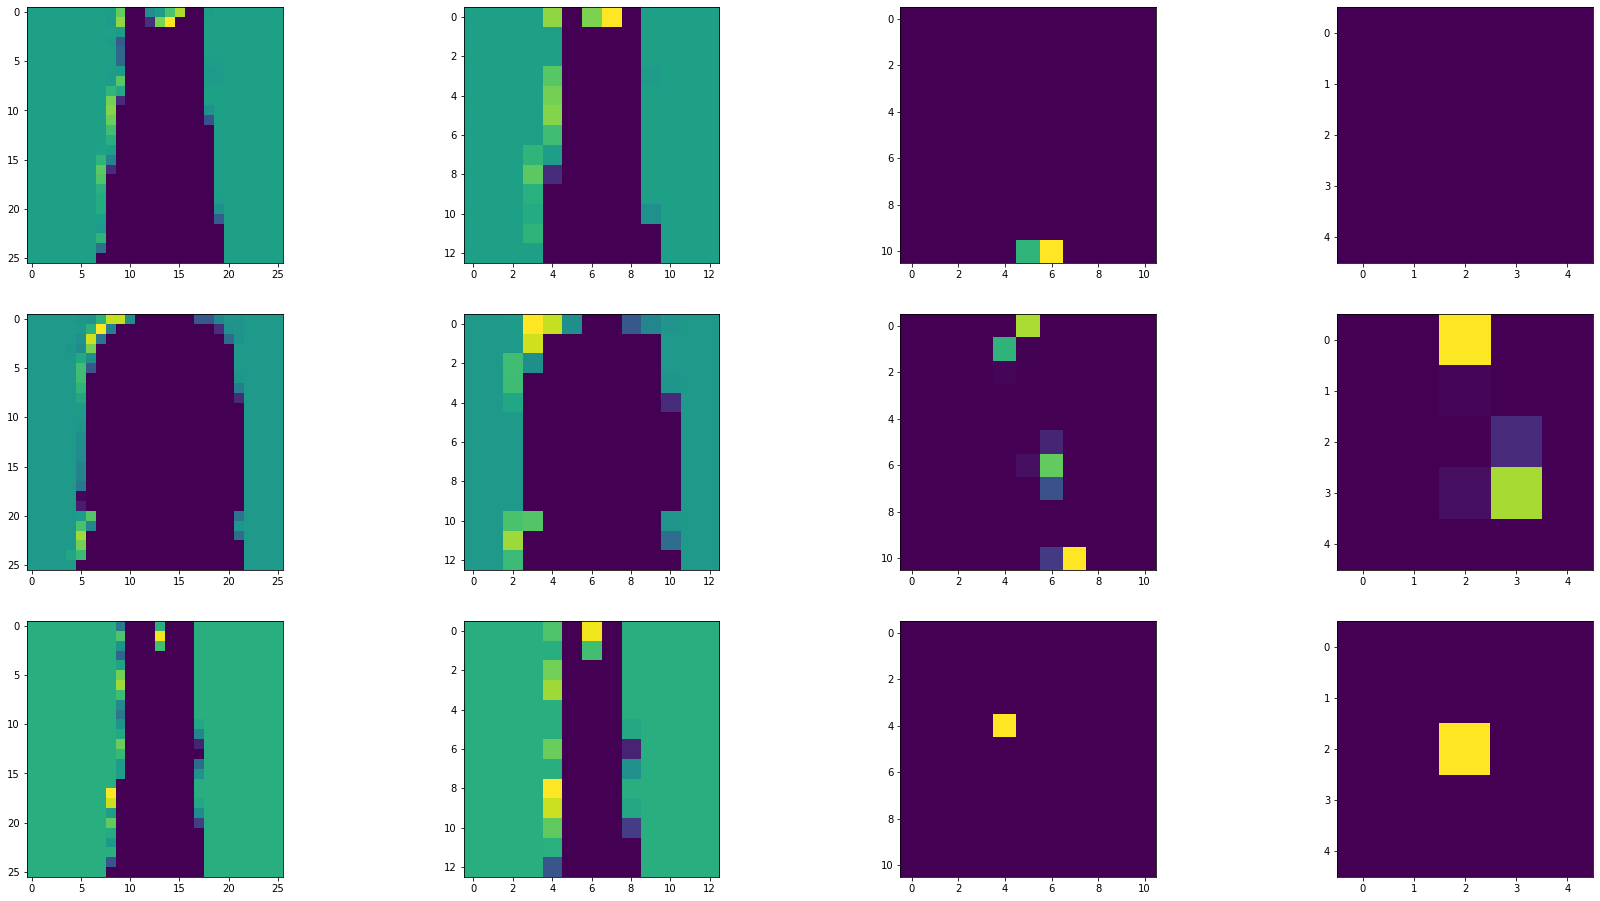

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 4: Coat

In [0]:
label_index = np.where(test_labels[:100]==4)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 6, 10, 14, 17, 25, 50, 51, 57, 79, 98])

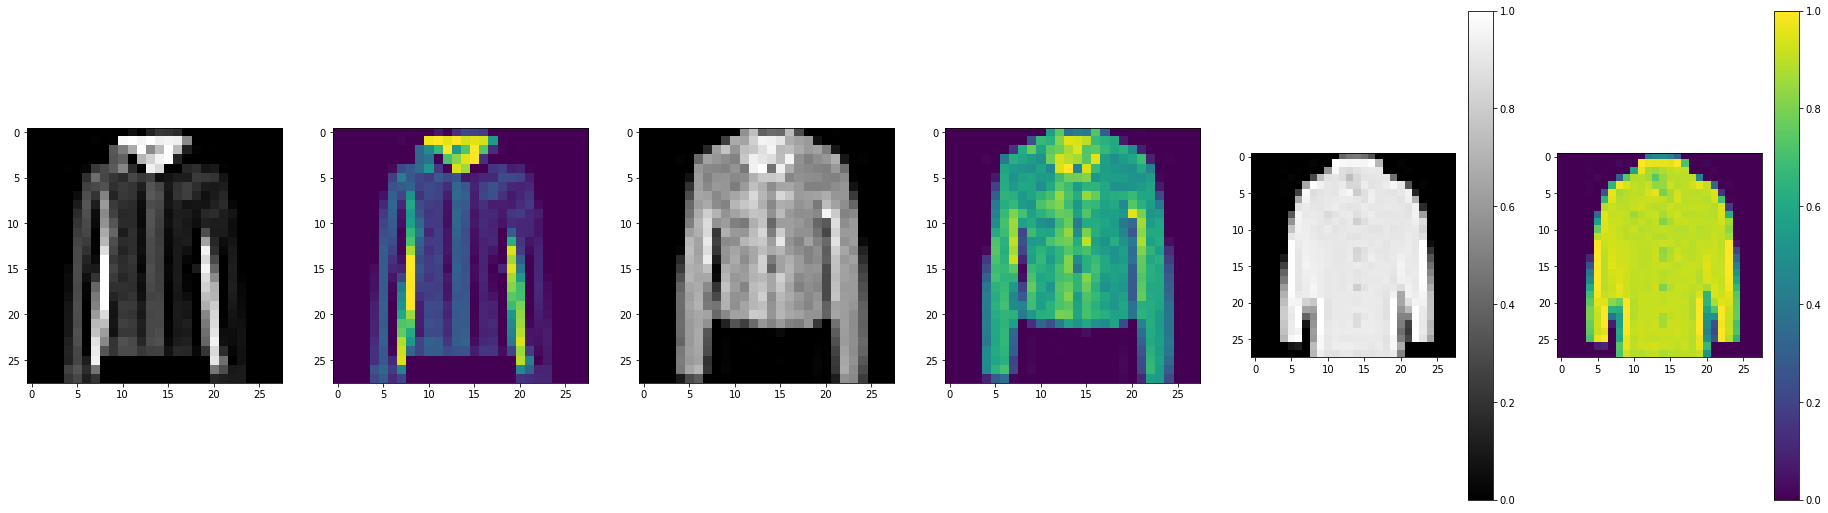

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 4: Coat after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

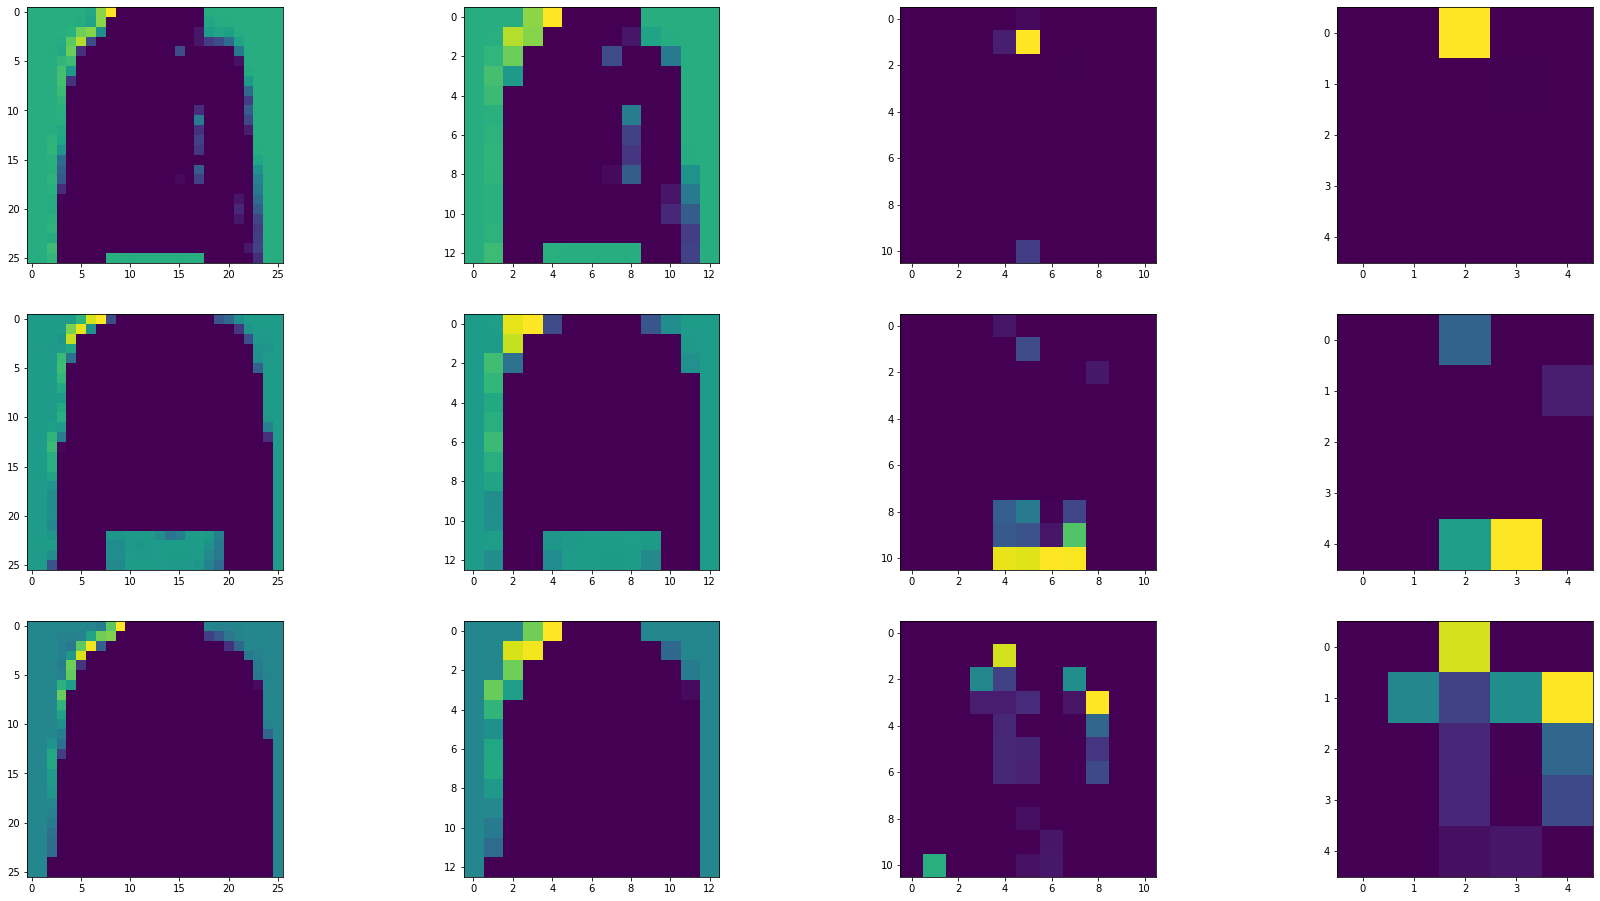

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 5: Sandal

In [0]:
label_index = np.where(test_labels[:100]==5)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 8, 11, 21, 37, 52, 63, 82, 84, 90])

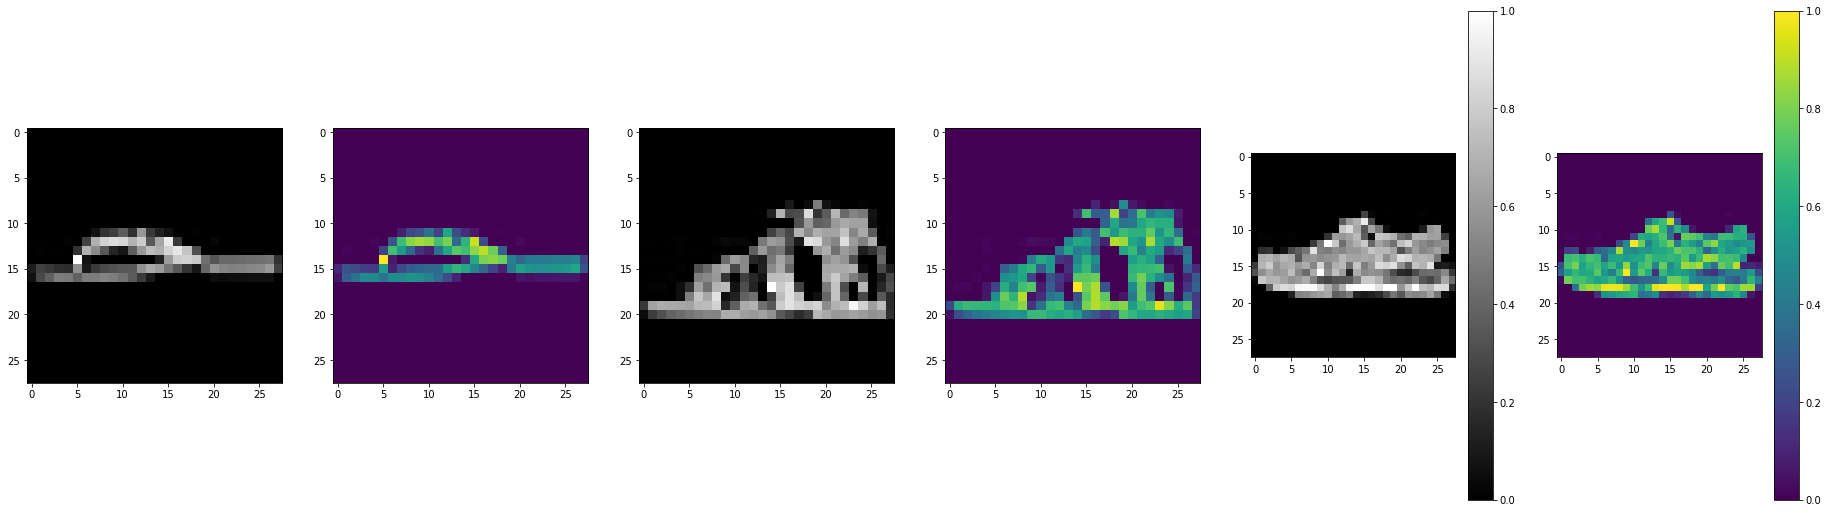

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 5: Sandal after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

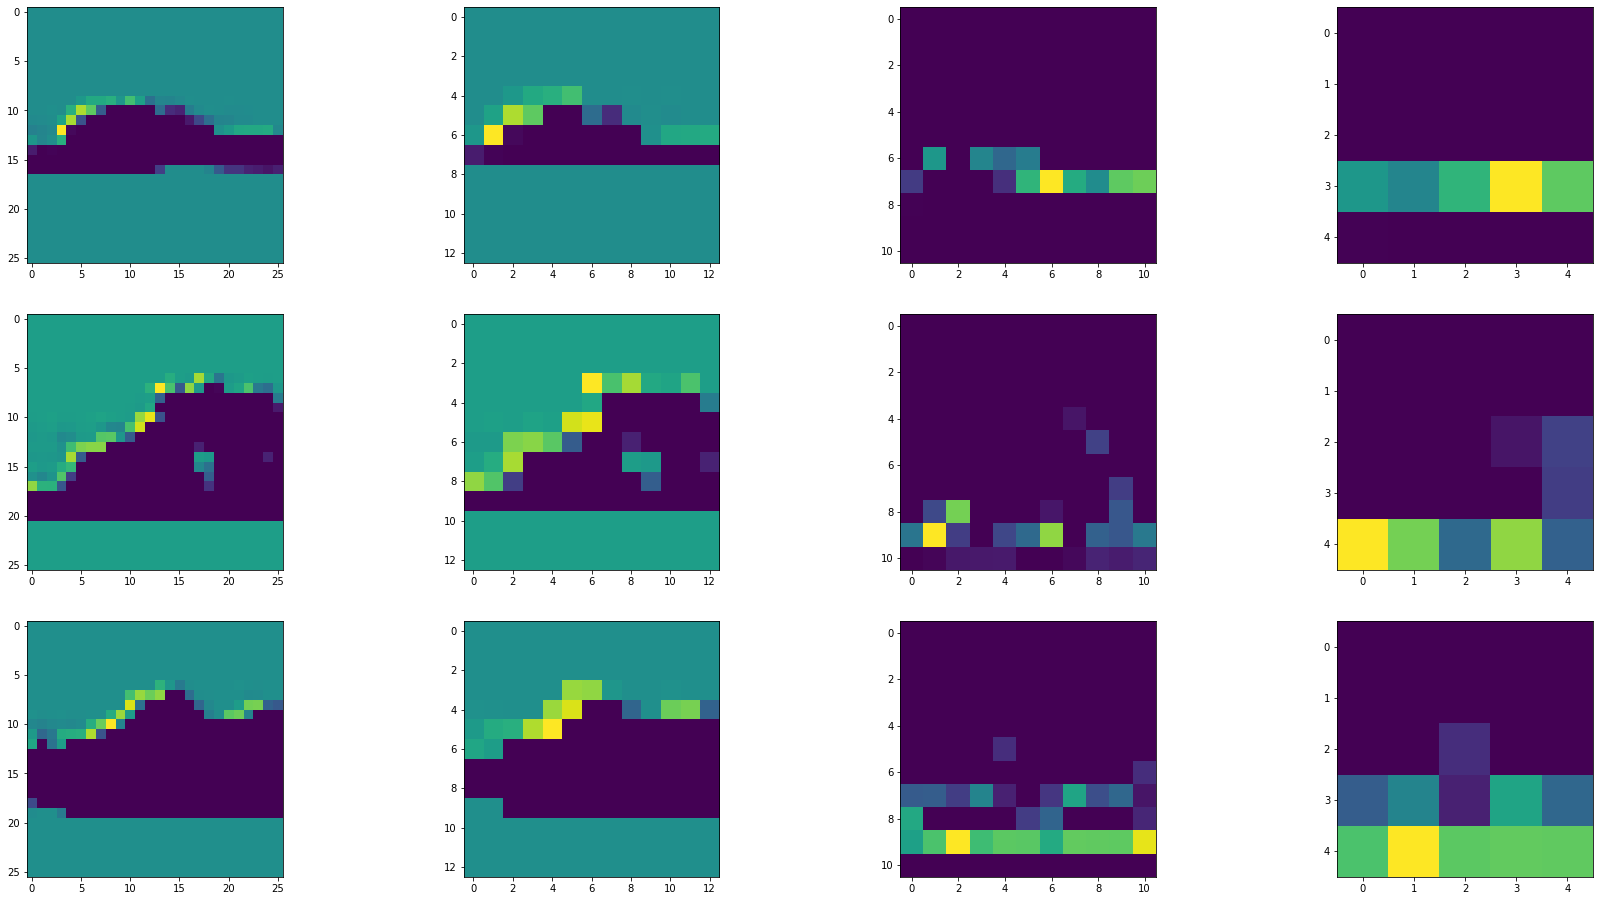

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 6: Shirt

In [0]:
label_index = np.where(test_labels[:100]==6)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 4,  7, 26, 40, 44, 73, 89, 92])

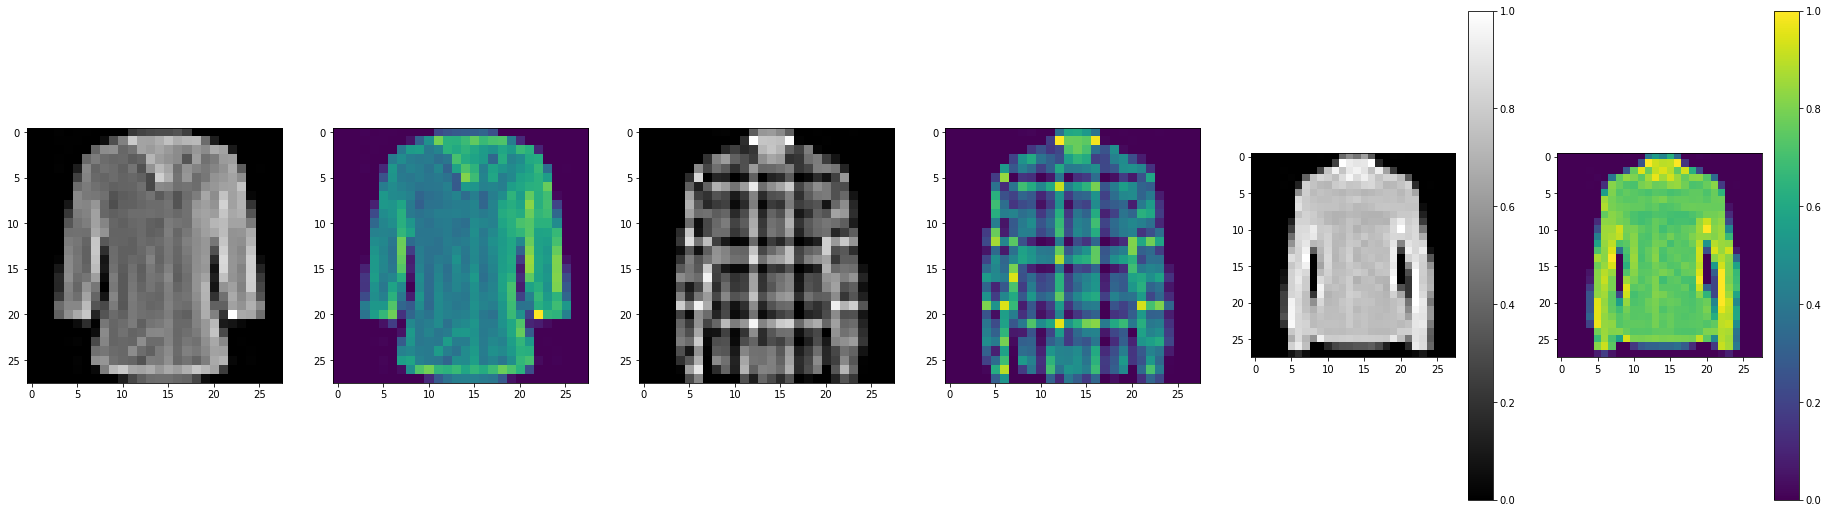

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 6: Shirt after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

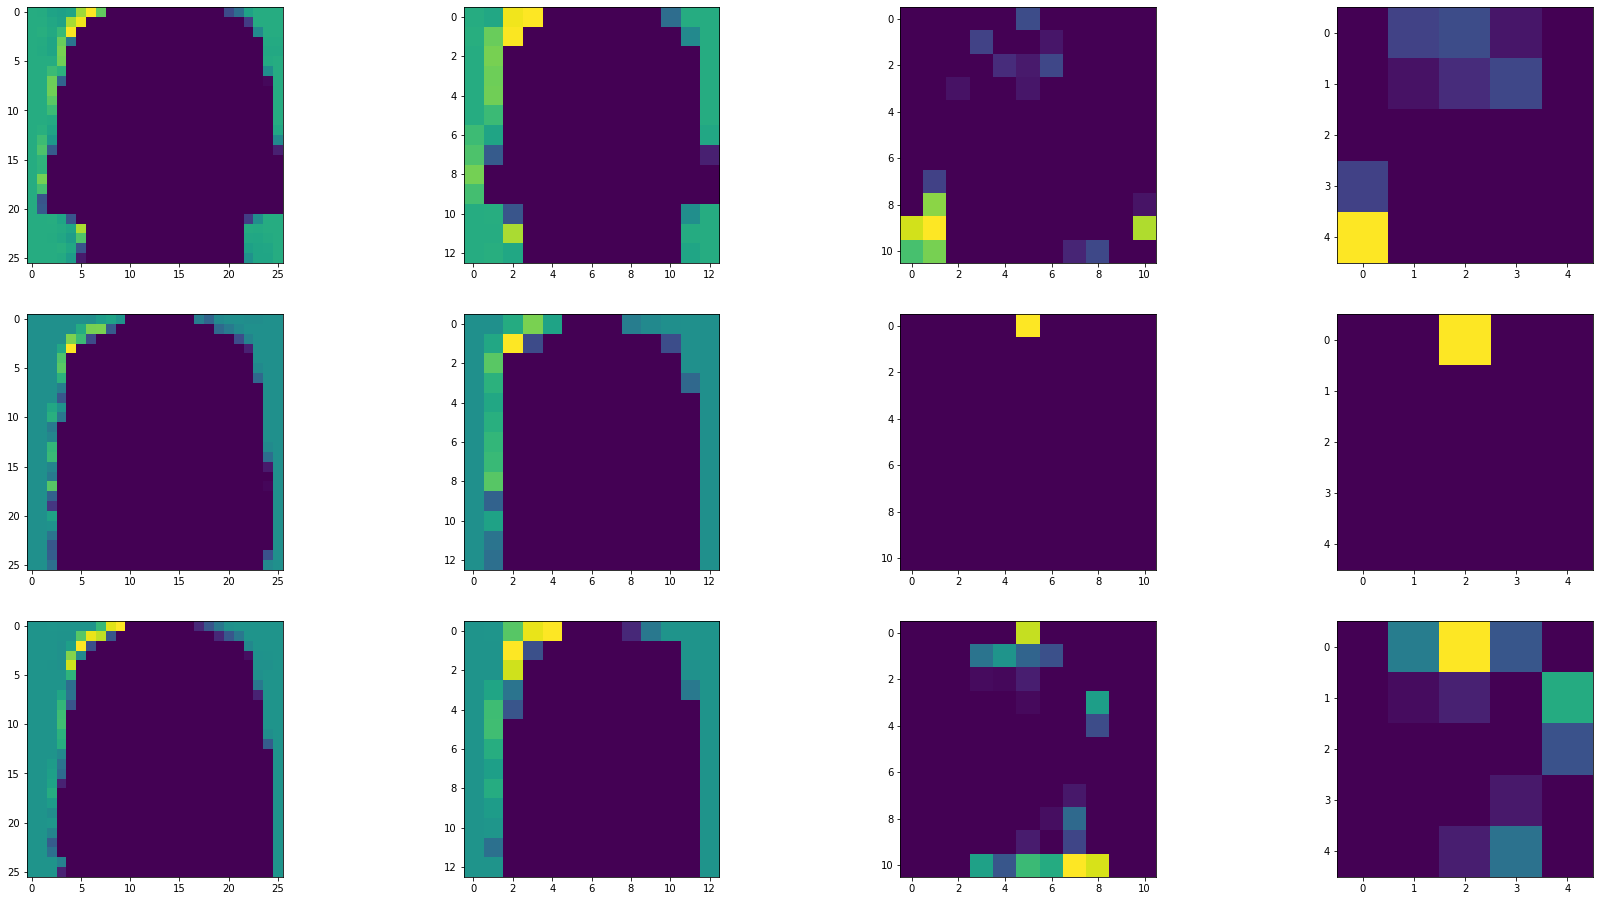

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 7: Sneaker

In [0]:
label_index = np.where(test_labels[:100]==7)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([ 9, 12, 22, 36, 38, 43, 45, 60, 61, 70, 93])

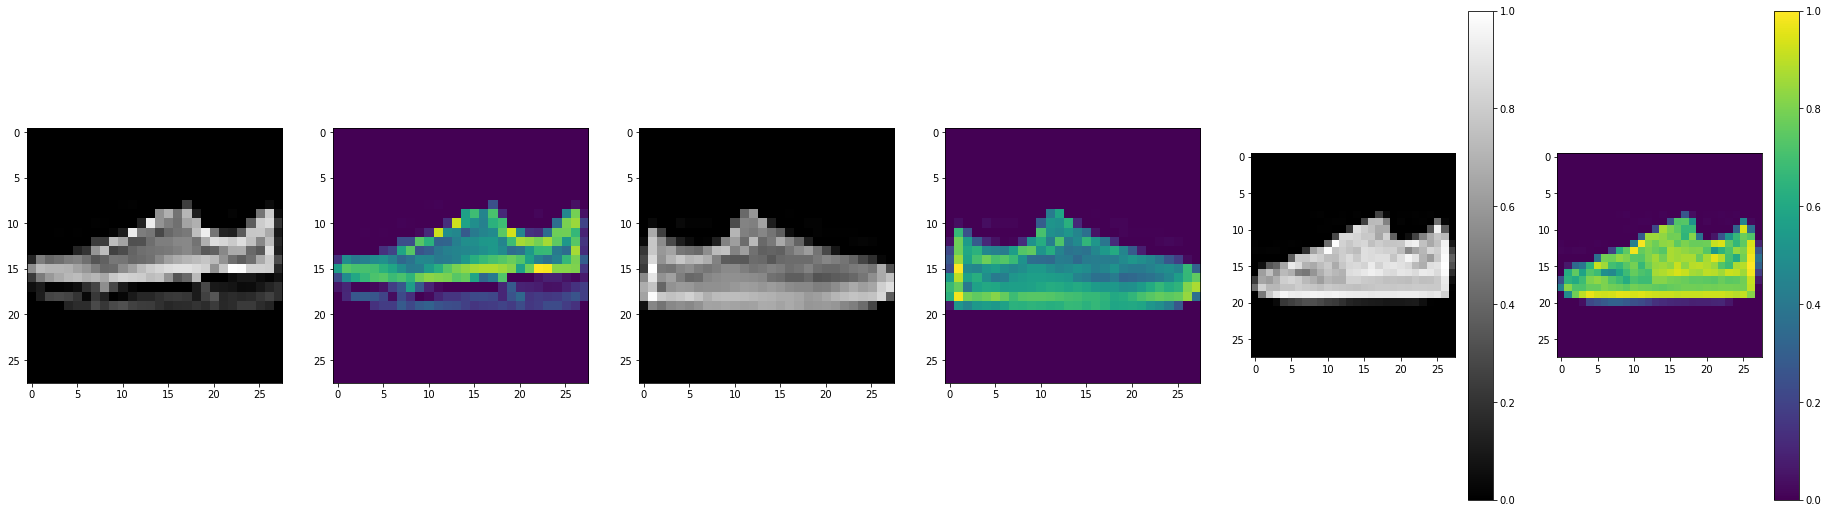

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 7: Sneaker after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

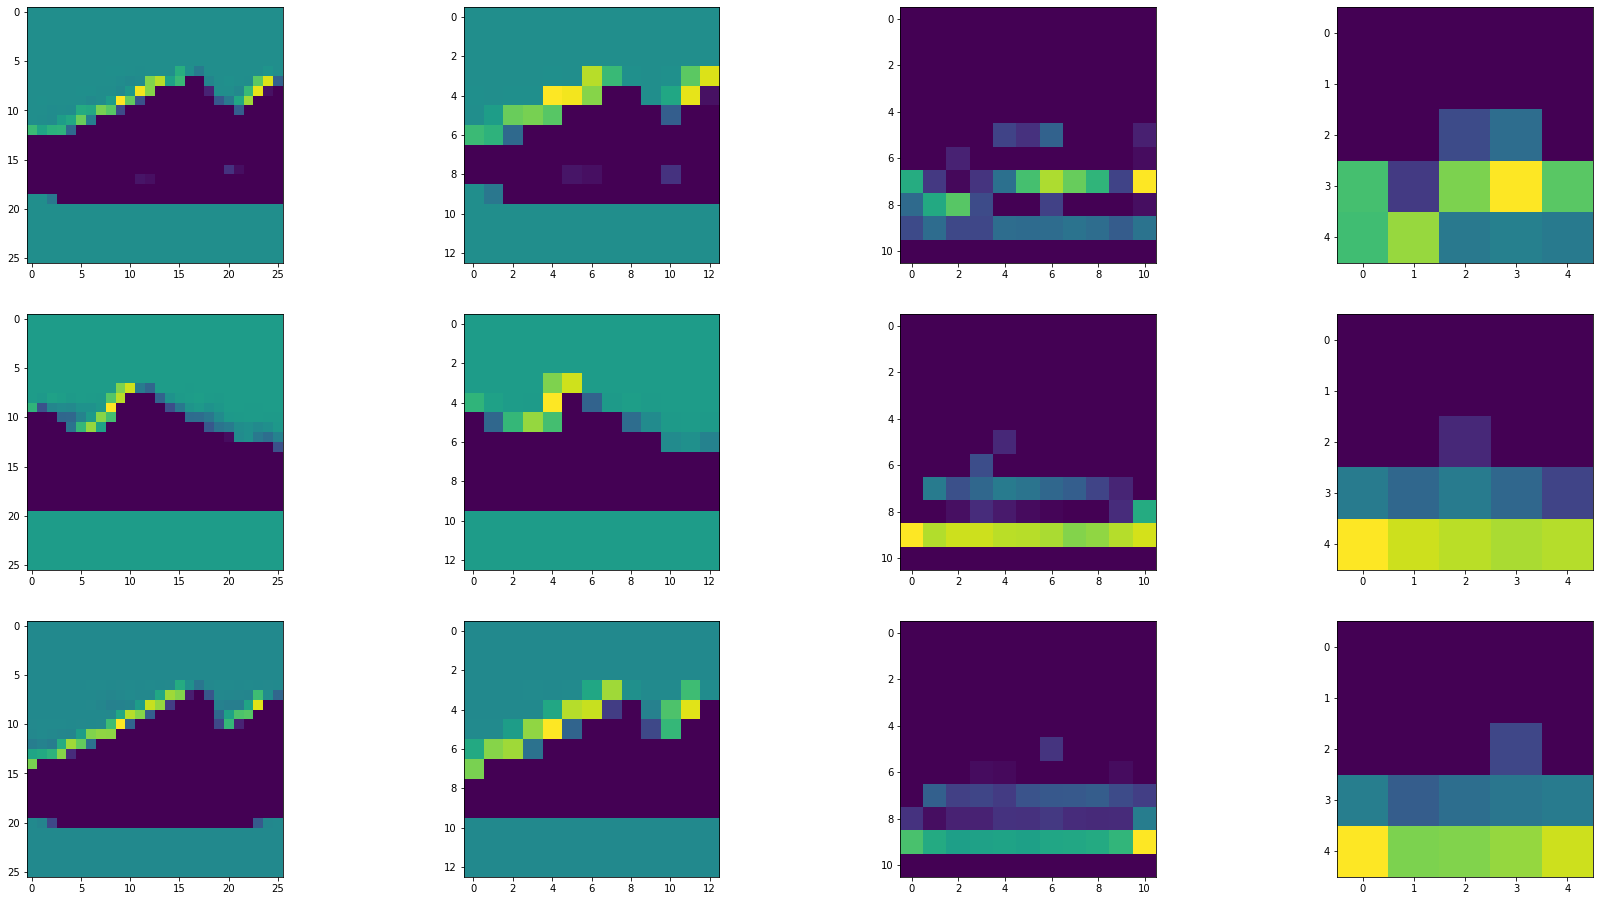

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 8: Bag

In [0]:
label_index = np.where(test_labels[:100]==8)[0]

FIRST_IMAGE=label_index[0]
SECOND_IMAGE=label_index[1]
THIRD_IMAGE=label_index[2]

label_index

array([18, 30, 31, 34, 53, 56, 58, 62, 69, 78, 81, 95])

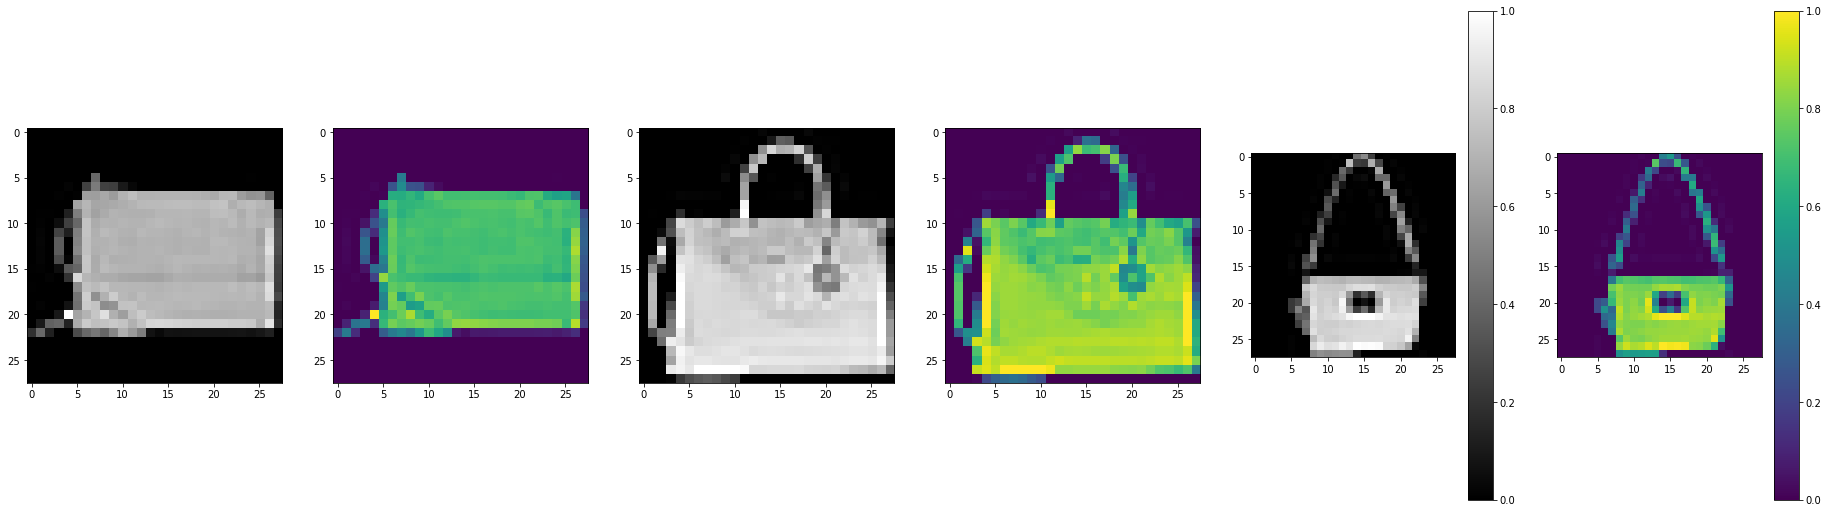

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 8: Bag after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

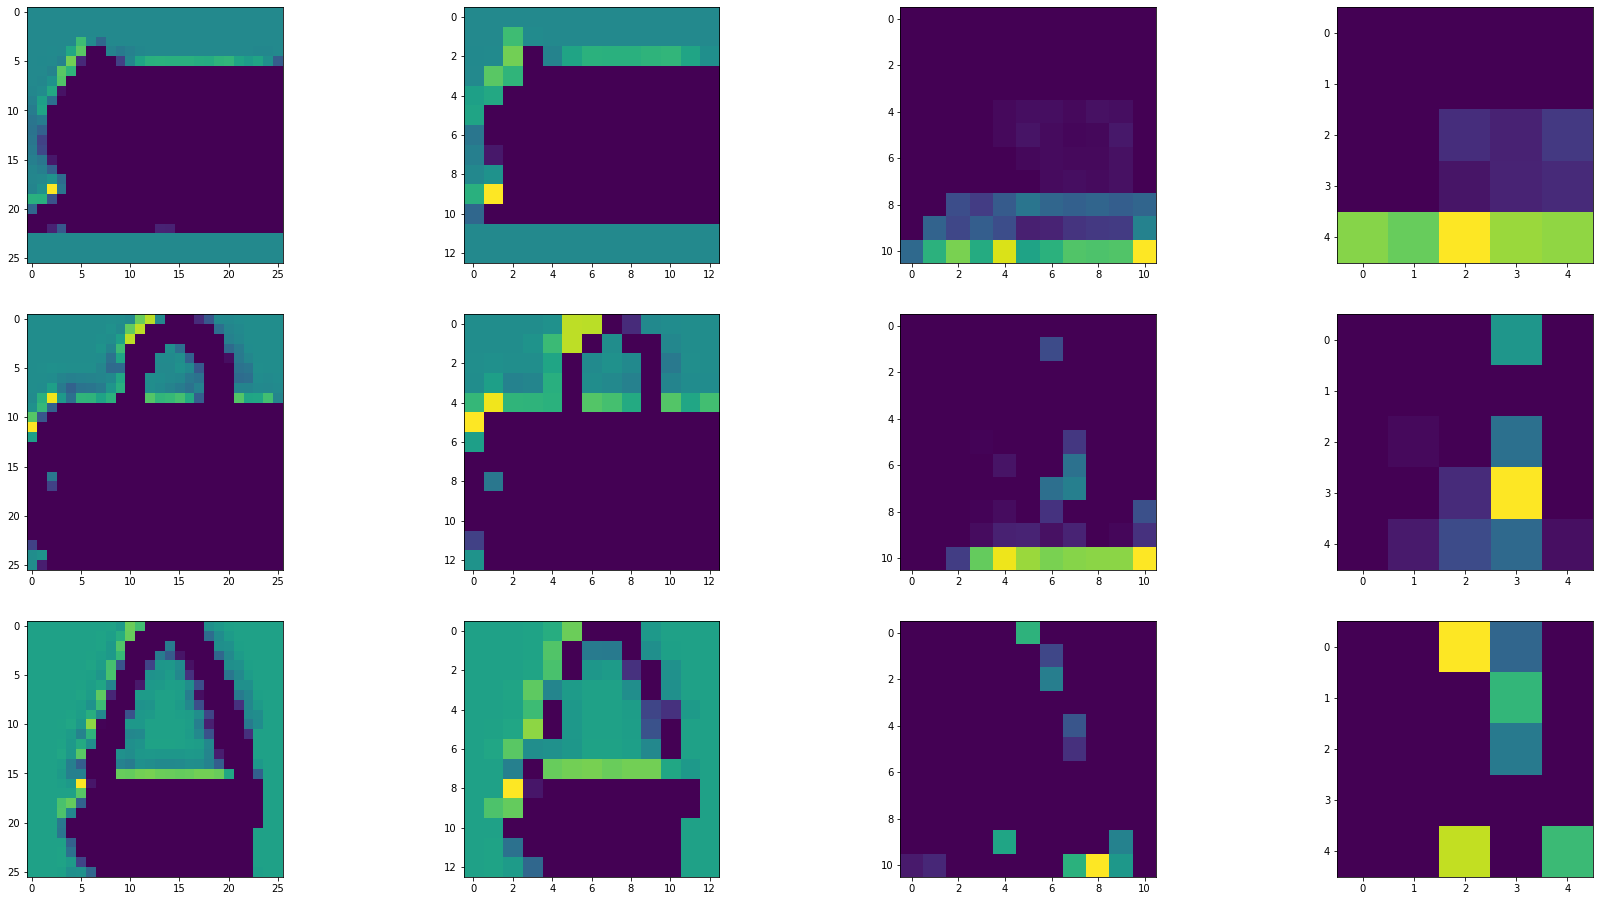

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)

## Let's look at 3 samples of label 9: Ankle boot 

In [0]:
label_index = np.where(test_labels[:100]==9)[0]

FIRST_IMAGE=label_index[3]
SECOND_IMAGE=label_index[4]
THIRD_IMAGE=label_index[5]

label_index

array([ 0, 23, 28, 39, 68, 83])

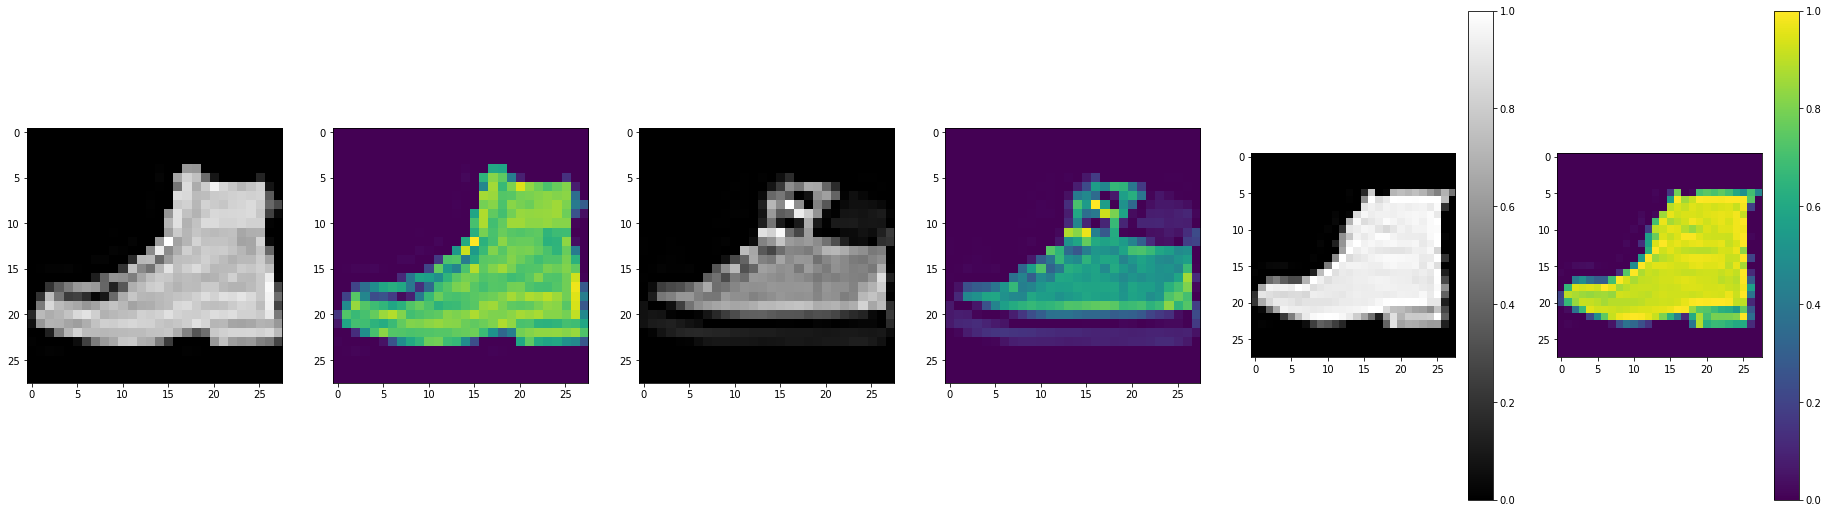

In [0]:
plt.figure(figsize=(32,9))

image = test_images[FIRST_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 2)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[SECOND_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 3)
plt.imshow(image, cmap='gray')
#plt.colorbar();
plt.subplot(1, 6, 4)
plt.imshow(image, cmap='viridis')
#plt.colorbar();

image = test_images[THIRD_IMAGE].reshape(28, 28)
plt.subplot(1, 6, 5)
plt.imshow(image, cmap='gray')
plt.colorbar();
plt.subplot(1, 6, 6)
plt.imshow(image, cmap='viridis')
plt.colorbar();

## Let's look at 3 samples of label 9: Ankle boot after each layer of our network, as produced by FILTER/CONVOLUTION_NUMBER 1 (0 to 63)

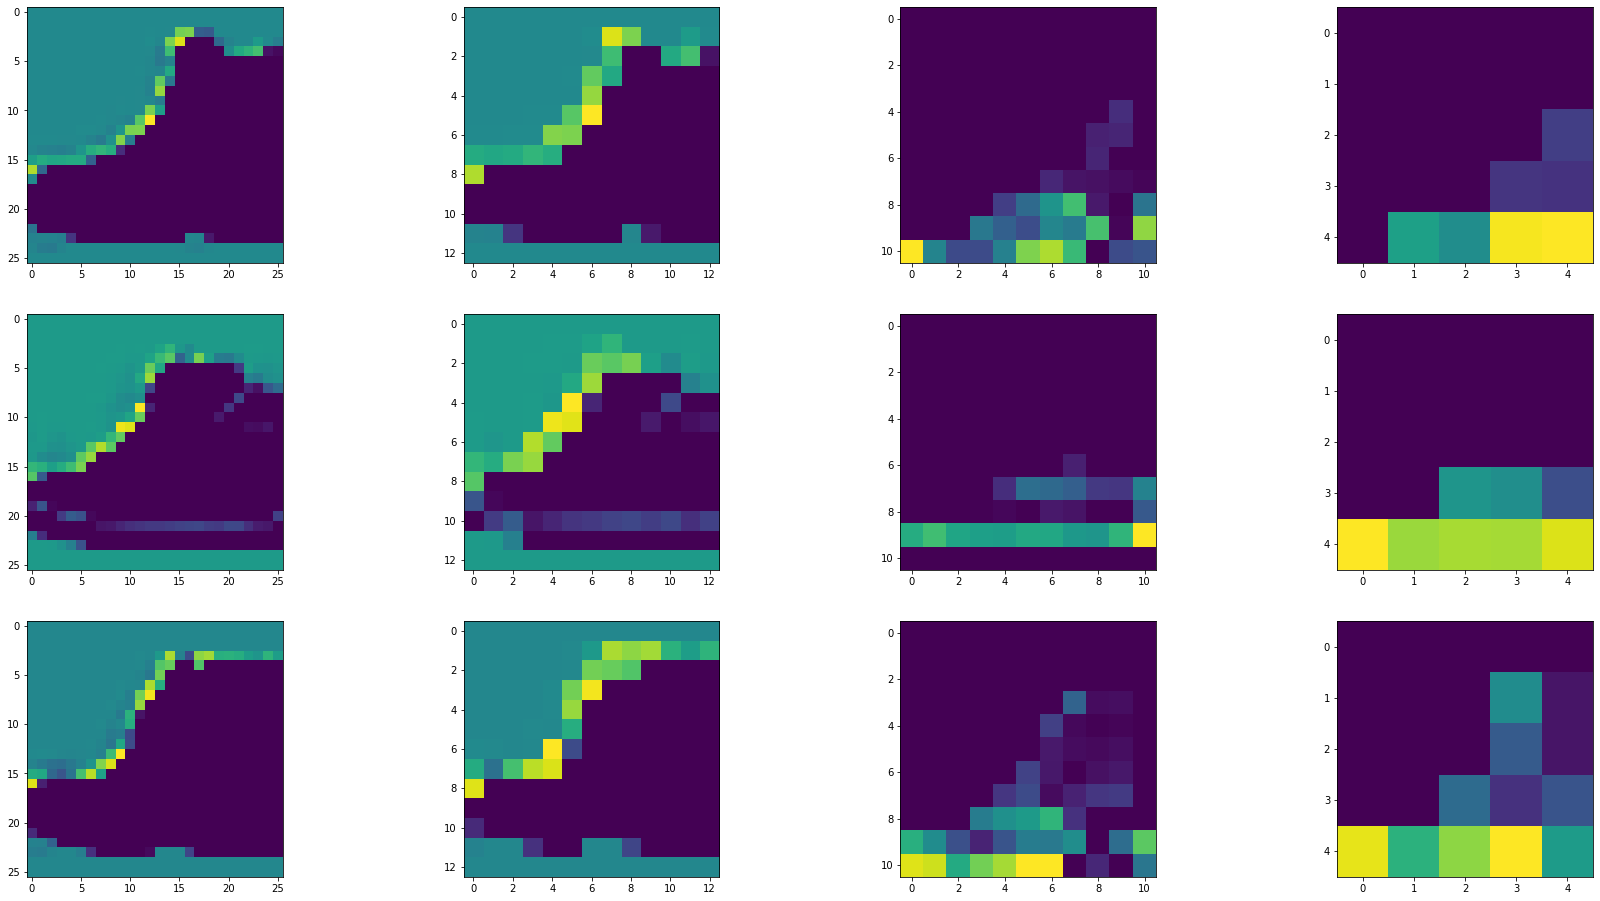

In [0]:
plt.rcParams["figure.figsize"] = [30,16]
f, axarr = plt.subplots(3,4)

CONVOLUTION_NUMBER = 1 #0 to 63

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[0,x].grid(False)

  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[1,x].grid(False)

  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
  axarr[2,x].grid(False)